In [1]:
# ============================================================================
# SECTION 0: REQUIRED PACKAGES
# ============================================================================

import numpy as np
import pandas as pd
from dsgepy import DSGE
from fredapi import Fred
from sympy import symbols, Matrix
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats, signal
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ============================================================================
# SECTION 1: UTILITY FUNCTIONS
# ============================================================================

def hp_filter(x, lambda_hp=1600):
    """
    HP filter implementation for proper output gap extraction.
    This version includes a fallback for short series to prevent errors.
    """
    T = len(x)
    if T < 4:
        return x, np.zeros(T)
        
    D2 = np.zeros((T-2, T))
    for i in range(T-2):
        D2[i, i] = 1
        D2[i, i+1] = -2
        D2[i, i+2] = 1
    
    I = np.eye(T)
    A = I + lambda_hp * D2.T @ D2
    try:
        trend = np.linalg.solve(A, x)
        cycle = x - trend
        return trend, cycle
    except np.linalg.LinAlgError:
        # Fallback to a linear trend if HP filter fails
        t = np.arange(T)
        coeffs = np.polyfit(t, x, 1)
        trend = np.polyval(coeffs, t)
        cycle = x - trend
        return trend, cycle

# ---- Begin Monkey-Patching Pandas HDFStore with Pickle ----
class DummyStore:
    def __init__(self, path):
        self.path = path.replace('.h5', '.pkl')
        self.data = {}
    def __setitem__(self, key, value):
        self.data[key] = value
    def __getitem__(self, key):
        return self.data[key]
    def close(self):
        with open(self.path, 'wb') as f:
            pickle.dump(self.data, f)

# Apply monkey-patches
pd.HDFStore = DummyStore
pd.read_hdf = lambda path, key=None, **kwargs: pickle.load(open(path.replace('.h5','.pkl'), 'rb'))[key]
pd.DataFrame.to_hdf = lambda self, path, key=None, **kwargs: pickle.dump({key: self}, open(path.replace('.h5','.pkl'),'wb'))
# ---- End Monkey-Patching ----

In [3]:
# ============================================================================
# SECTION 2: DATA INGESTION AND TRANSFORMATION
# ============================================================================

# Your FRED API key
afkey = 'ada1a8ba0569ed784226f2c26db44ab1'
fred = Fred(api_key=afkey)

# Set the end date to today and let the code find the last available date
start = '1990-01-01'
end = pd.Timestamp.today().strftime('%Y-%m-%d')

series = {
    'gdp': fred.get_series('GDPC1', start, end),
    'cpi': fred.get_series('CPILFESL', start, end), # Using Core CPI
    'fed': fred.get_series('FEDFUNDS', start, end),
    'tfp': fred.get_series('A191RL1Q225SBEA', start, end),
}

# Combine and then drop NaNs. This ensures we get the most recent date
# where ALL series have a value.
raw_data = pd.DataFrame(series).resample('Q-DEC').last().dropna()  # Calendar quarters

# Get the actual end date from the cleaned raw_data
end = raw_data.index[-1].strftime('%Y-%m-%d')
print(f"Using sample period: {start} to {end}")
print(f"Raw data shape: {raw_data.shape}")

# ===== IMPROVED TRANSFORMATIONS =====

# 1. PROPER OUTPUT GAP using HP filter
print("\n🔧 MAJOR FIX: Creating proper output gap using HP filter...")
log_gdp = np.log(raw_data['gdp'])
gdp_trend, output_gap = hp_filter(log_gdp.values, lambda_hp=1600)
output_gap = pd.Series(output_gap, index=raw_data.index)

# 2. IMPROVED INFLATION using Core CPI
print("\n🔧 IMPROVEMENT: Using Core CPI for inflation...")
inflation_quarterly = np.log(raw_data['cpi']).diff()

# 3. 🚨 CRITICAL FIX: BETTER INTEREST RATE TRANSFORMATION (REMOVED center=True)
print("\n🔧 CRITICAL FIX: Removing center=True from interest rate trend...")
fed_funds = raw_data['fed']
fed_trend = fed_funds.rolling(window=20, min_periods=10).mean()
fed_trend = fed_trend.bfill().ffill()
interest_gap = fed_funds - fed_trend

print(f"🔍 CONTINUITY CHECK:")
print(f"   Last observed fed rate: {fed_funds.iloc[-1]:.4f}")
print(f"   Last trend value: {fed_trend.iloc[-1]:.4f}")  
print(f"   Calculated gap: {fed_funds.iloc[-1] - fed_trend.iloc[-1]:.4f}")
print(f"   Actual gap in data: {interest_gap.iloc[-1]:.4f}")

# 4. TFP (Corrected Transformation)
print("\n🔧 FIX: Correcting TFP transformation...")
tfp_demeaned = raw_data['tfp'] - raw_data['tfp'].mean()

# Combine into improved dataset
data = pd.DataFrame({
    'y':  output_gap,
    'pi': inflation_quarterly,
    'i':  interest_gap,
    'a':  tfp_demeaned
})

# Drop missing values *after* all transformations
data = data.dropna()

print("\n📊 IMPROVED DATA SUMMARY AFTER TRANSFORMATIONS:")
print("-" * 50)
for col in data.columns:
    mean_val = data[col].mean()
    std_val = data[col].std()
    min_val = data[col].min()
    max_val = data[col].max()
    print(f"{col}: mean={mean_val:+7.4f}, std={std_val:6.4f}, range=[{min_val:+7.4f}, {max_val:+7.4f}]")

print(f"\nImproved data shape: {data.shape}")

# Create the df_obs variable used by the forecasting functions
df_obs = data[['y', 'pi', 'i']].copy()

print("\n✅ Data ingestion and transformation complete.")

Using sample period: 1990-01-01 to 2025-06-30
Raw data shape: (142, 4)

🔧 MAJOR FIX: Creating proper output gap using HP filter...

🔧 IMPROVEMENT: Using Core CPI for inflation...

🔧 CRITICAL FIX: Removing center=True from interest rate trend...
🔍 CONTINUITY CHECK:
   Last observed fed rate: 4.3300
   Last trend value: 2.8940
   Calculated gap: 1.4360
   Actual gap in data: 1.4360

🔧 FIX: Correcting TFP transformation...

📊 IMPROVED DATA SUMMARY AFTER TRANSFORMATIONS:
--------------------------------------------------
y: mean=-0.0002, std=0.0126, range=[-0.0894, +0.0236]
pi: mean=+0.0064, std=0.0034, range=[-0.0045, +0.0224]
i: mean=-0.1261, std=1.7567, range=[-3.3195, +3.5800]
a: mean=-0.0130, std=4.4807, range=[-30.6725, +32.6275]

Improved data shape: (141, 4)

✅ Data ingestion and transformation complete.


In [4]:
# ============================================================================
# SECTION 3: DSGE MODEL SPECIFICATION
# ============================================================================

# --- Define symbols ---
# endogenous variables at t
y, pi, i, a, v, exp_y, exp_pi = symbols('y, pi, i, a, v, exp_y, exp_pi')
endog = Matrix([y, pi, i, a, v, exp_y, exp_pi])

# endogenous variables at t-1
yl, pil, il, al, vl, exp_yl, exp_pil = symbols('yl, pil, il, al, vl, exp_yl, exp_pil')
endogl = Matrix([yl, pil, il, al, vl, exp_yl, exp_pil])

# exogenous shocks
eps_a, eps_v, eps_pi = symbols('eps_a, eps_v, eps_pi')
exog = Matrix([eps_a, eps_v, eps_pi])

# expectational shocks
eta_y, eta_pi = symbols('eta_y, eta_pi')
expec = Matrix([eta_y, eta_pi])

# parameters
sigma, varphi, alpha, beta, theta, phi_pi, phi_y, rho_a, sigma_a, rho_v, sigma_v, sigma_pi = \
    symbols('sigma varphi alpha beta theta phi_pi phi_y rho_a sigma_a rho_v sigma_v sigma_pi')

# summary parameters
psi_nya = (1 + varphi) / (sigma * (1 - alpha) + varphi + alpha)
kappa = (1 - theta) * (1 - theta * beta) * (sigma * (1 - alpha) + varphi + alpha) / theta

# state equations
eq1 = y - exp_y + (1/sigma)*(i - exp_pi) - psi_nya*(rho_a - 1)*a
eq2 = pi - beta*exp_pi - kappa*y - sigma_pi*eps_pi
eq3 = i - phi_pi*pi - phi_y*y - v
eq4 = a - rho_a*al - sigma_a*eps_a
eq5 = v - rho_v*vl - sigma_v*eps_v
eq6 = y - exp_yl - eta_y
eq7 = pi - exp_pil - eta_pi
equations = Matrix([eq1, eq2, eq3, eq4, eq5, eq6, eq7])

# observation equations
obs01 = y
obs02 = pi
obs03 = i
obs_equations = Matrix([obs01, obs02, obs03])
obs_names = ['Output Gap', 'Inflation', 'Interest Rate']


🔧 IMPROVED CALIBRATION:
------------------------------
✅ Calibration Summary:
   Risk aversion (σ): 1.0
   Price stickiness (θ): 0.837
   Phillips curve slope (κ): 0.1000 (target: 0.1)
   Price duration: 6.1 quarters
   Taylor rule inflation coef: 2.0 (>1 ✅)
   Taylor rule output coef: 0.5

🔍 Model Solution Check:
   Existence & Uniqueness: [1, 1]
   ✅ Model has unique stable solution!

📈 Generating theoretical impulse responses...


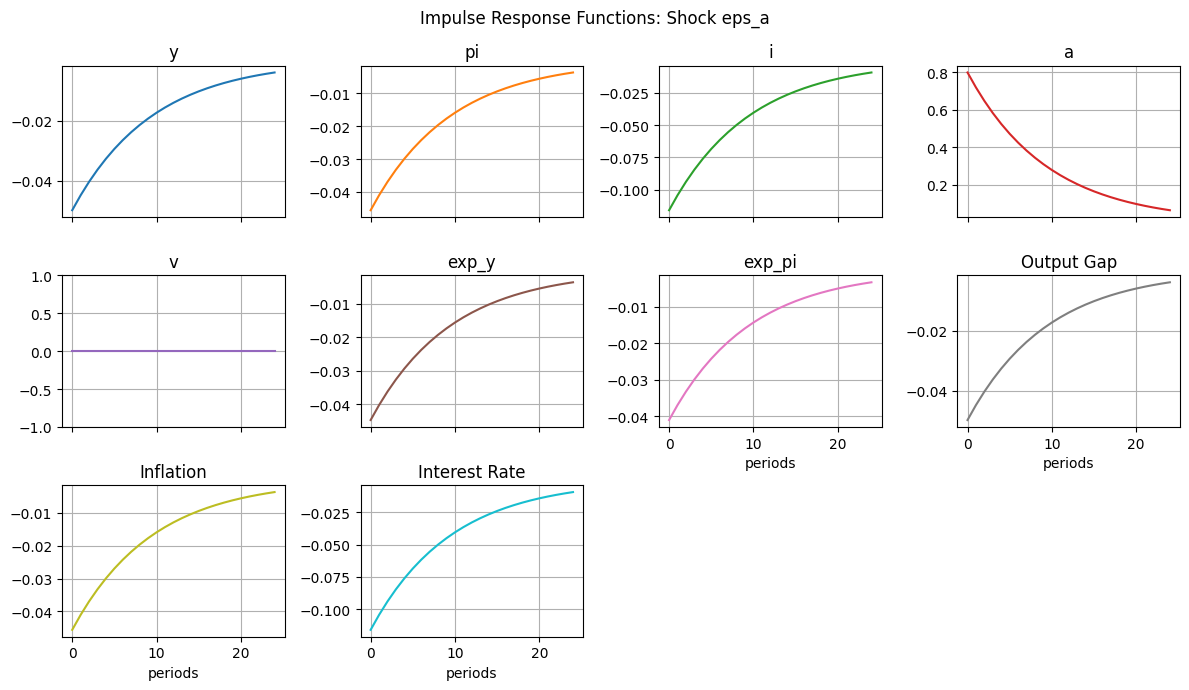

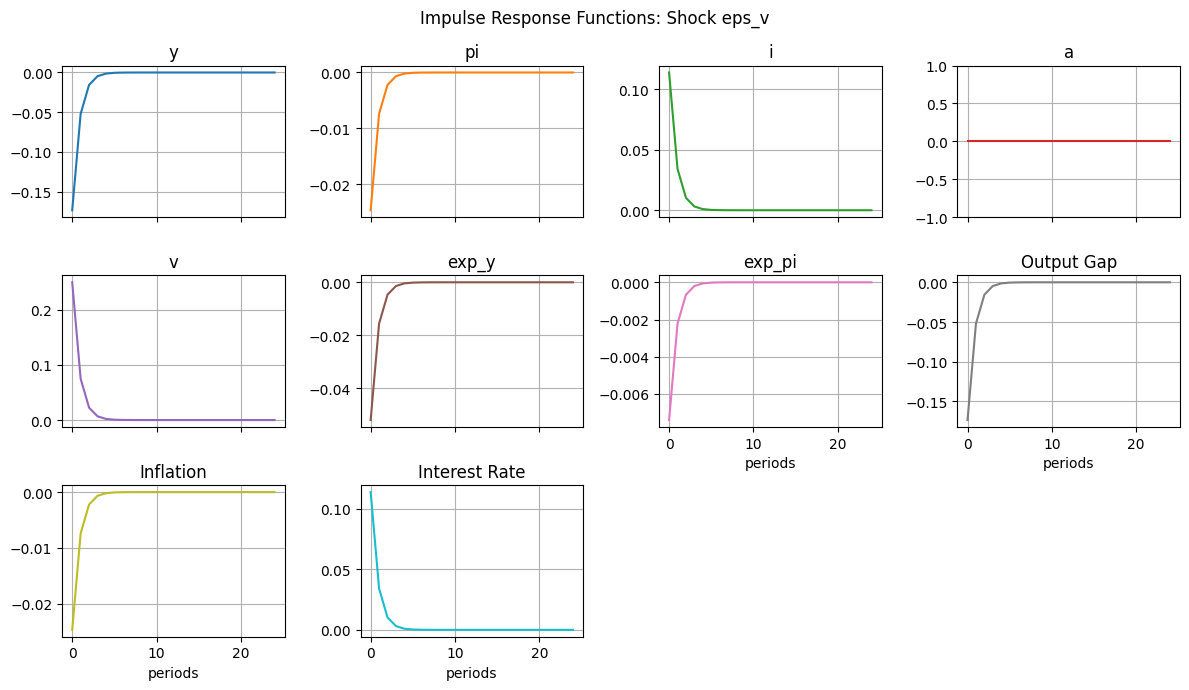

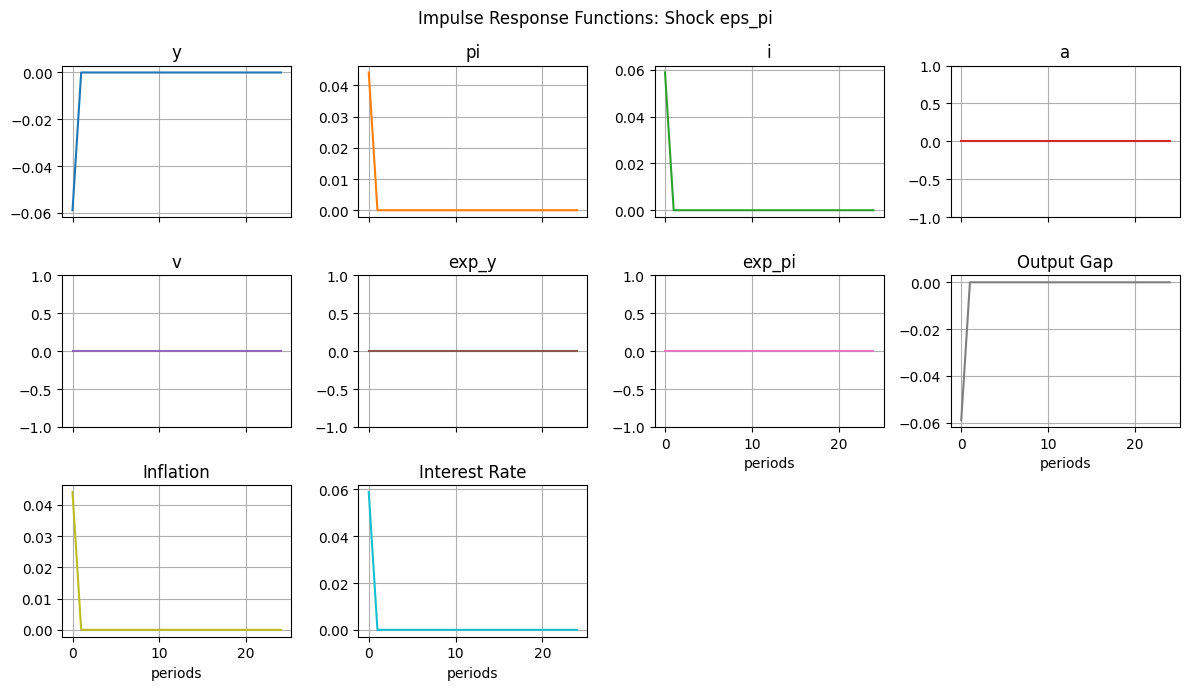

y        pi         i        a    v     exp_y  \
exog   periods                                                         
eps_a  0       -0.049715  -0.04561 -0.116078      0.8 -0.0 -0.044743   
       1       -0.044743 -0.041049  -0.10447     0.72 -0.0 -0.040269   
       2       -0.040269 -0.036944 -0.094023    0.648 -0.0 -0.036242   
       3       -0.036242  -0.03325 -0.084621   0.5832 -0.0 -0.032618   
       4       -0.032618 -0.029925 -0.076158  0.52488  0.0 -0.029356   
...                  ...       ...       ...      ...  ...       ...   
eps_pi 20           -0.0      -0.0      -0.0      0.0 -0.0      -0.0   
       21           -0.0      -0.0      -0.0      0.0 -0.0      -0.0   
       22           -0.0      -0.0      -0.0      0.0 -0.0      -0.0   
       23           -0.0      -0.0      -0.0      0.0 -0.0      -0.0   
       24           -0.0      -0.0      -0.0      0.0 -0.0      -0.0   

                  exp_pi Output Gap Inflation Interest Rate  
exog   periods                                               
eps_a  0       -0.041049  -0.049715  -0.04561     -0.116078  
       1       -0.036944  -0.044743 -0.041049      -0.10447  
       2        -0.03325  -0.040269 -0.036944     -0.094023  
       3       -0.029925  -0.036242  -0.03325     -0.084621  
       4       -0.026932  -0.032618 -0.029925     -0.076158  
...                  ...        ...       ...           ...  
eps_pi 20           -0.0       -0.0      -0.0          -0.0  
       21           -0.0       -0.0      -0.0          -0.0  
       22           -0.0       -0.0      -0.0          -0.0  
       23           -0.0       -0.0      -0.0          -0.0  
       24           -0.0       -0.0      -0.0          -0.0  

[75 rows x 10 columns]

In [5]:
# ============================================================================
# SECTION 4: IMPROVED CALIBRATION 
# ============================================================================

def solve_calvo_parameter(target_kappa, sigma_val, varphi_val, alpha_val, beta_val):
    slope_factor = (sigma_val * (1 - alpha_val) + varphi_val + alpha_val)
    
    A = beta_val * slope_factor
    B = -(1 + beta_val) * slope_factor - target_kappa
    C = slope_factor
    
    discriminant = B**2 - 4*A*C
    if discriminant >= 0:
        theta1 = (-B - np.sqrt(discriminant)) / (2*A)
        theta2 = (-B + np.sqrt(discriminant)) / (2*A)
        
        valid_solutions = [theta for theta in [theta1, theta2] if 0 < theta < 1]
        if valid_solutions:
            return valid_solutions[0]
    
    # Better fallback based on target_kappa
    return min(0.99, max(0.01, 1 - target_kappa/slope_factor))

# FIXED CALIBRATION - More realistic values
print("\n🔧 IMPROVED CALIBRATION:")
print("-" * 30)

# Target a reasonable Phillips curve slope
target_kappa = 0.10  # More realistic than 0.15
theta_target = solve_calvo_parameter(target_kappa, 1.0, 2.0, 0.33, 0.99)

calib = {
    sigma:   1.0,      # Lower risk aversion (more realistic)
    varphi:  2.0,      # Higher Frisch elasticity inverse  
    alpha:   0.33,     # Standard capital share
    beta:    0.99,     # Standard quarterly discount factor
    theta:   theta_target,  # Computed to get reasonable kappa
    phi_pi:  2.0,      # Stronger inflation response (satisfies Taylor principle)
    phi_y:   0.5,      # Higher output response
    rho_a:   0.9,      # TFP persistence
    sigma_a: 0.8,      # TFP volatility  
    rho_v:   0.3,      # Monetary shock persistence
    sigma_v: 0.25,     # Monetary shock volatility
    sigma_pi:0.05      # Cost-push shock volatility
}

# Verify the calibration
kappa_actual = ((1 - theta_target) * (1 - theta_target * 0.99) / theta_target * (1.0 * (1 - 0.33) + 2.0 + 0.33))
price_duration = 1/(1-theta_target)

print(f"✅ Calibration Summary:")
print(f"   Risk aversion (σ): {calib[sigma]}")
print(f"   Price stickiness (θ): {theta_target:.3f}")
print(f"   Phillips curve slope (κ): {kappa_actual:.4f} (target: {target_kappa})")
print(f"   Price duration: {price_duration:.1f} quarters")
print(f"   Taylor rule inflation coef: {calib[phi_pi]} (>1 ✅)")
print(f"   Taylor rule output coef: {calib[phi_y]}")

# Instantiate DSGE model with improved calibration
model = DSGE(
    endog=endog,
    endogl=endogl,
    exog=exog,
    expec=expec,
    state_equations=equations,
    obs_equations=obs_equations,
    obs_names=obs_names,
    calib_dict=calib
)

# Check existence and uniqueness
print(f'\n🔍 Model Solution Check:')
print(f'   Existence & Uniqueness: {model.eu}')

if model.eu == [1, 1]:
    print('   ✅ Model has unique stable solution!')
else:
    print('   ❌ Model solution issues - check calibration')

# Theoretical IRFs
print('\n📈 Generating theoretical impulse responses...')
model.irf(periods=24, show_charts=True)

Metropolis-Hastings: 100%|██████████| 1999/1999 [02:41<00:00, 12.39it/s]


Acceptance rate: 53.6 percent


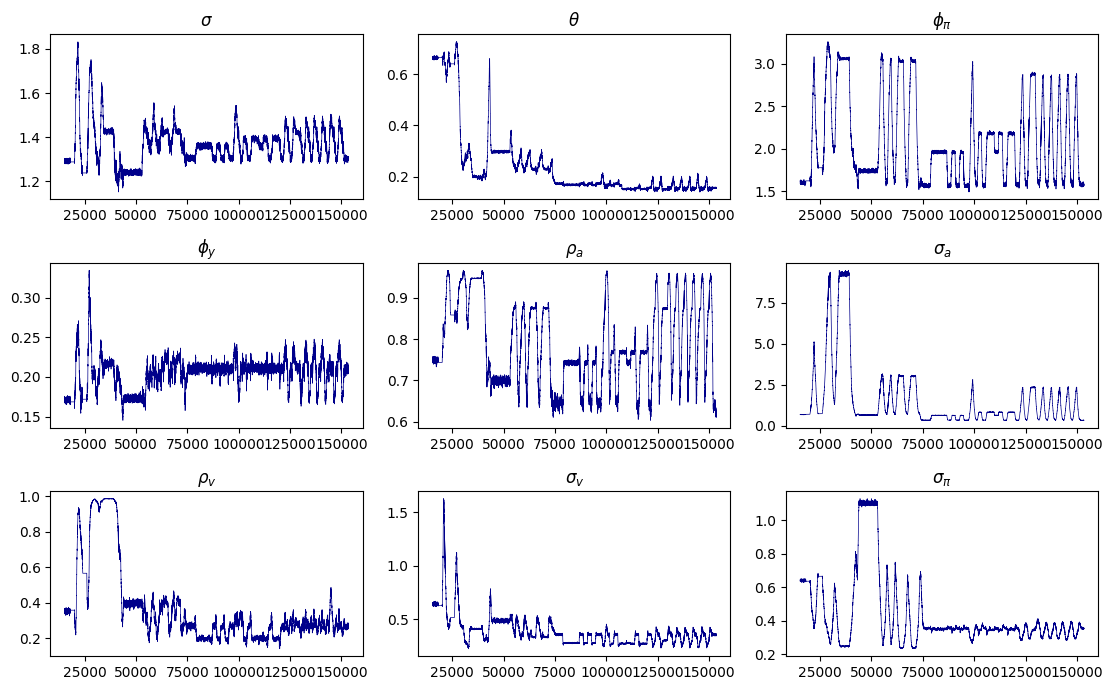

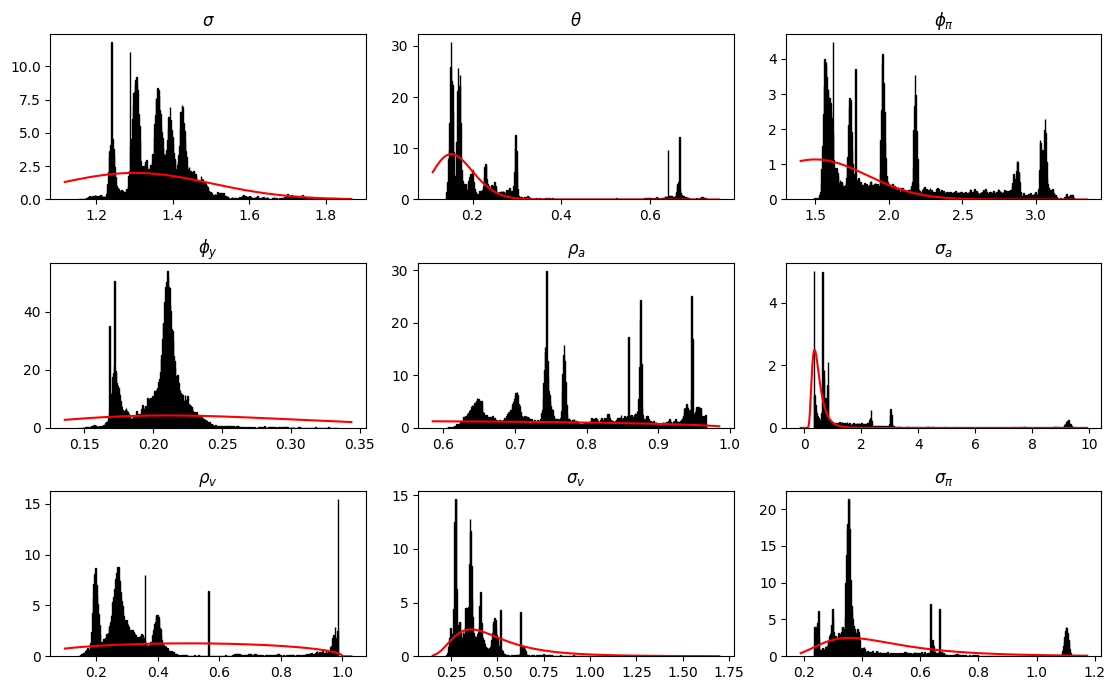

         prior dist prior mean prior std  posterior mode  posterior mean  \
sigma        normal        1.3       0.2        1.237633        1.366395   
theta          beta   0.837091       0.1        0.640577        0.243849   
phi_pi       normal        1.5      0.35        1.774790        2.086240   
phi_y         gamma       0.25       0.1        0.171834        0.204169   
rho_a          beta        0.5      0.25        0.858850        0.788690   
sigma_a    invgamma        0.5      0.25        0.731159        1.596425   
rho_v          beta        0.5      0.25        0.566325        0.374378   
sigma_v    invgamma        0.5      0.25        0.514623        0.383488   
sigma_pi   invgamma        0.5      0.25        0.665799        0.434949   

          posterior 5.0%  posterior 95.0%  
sigma           1.237633         1.500394  
theta           0.148575         0.661878  
phi_pi          1.561987         3.058638  
phi_y           0.170076         0.232061  
rho_a           0.6

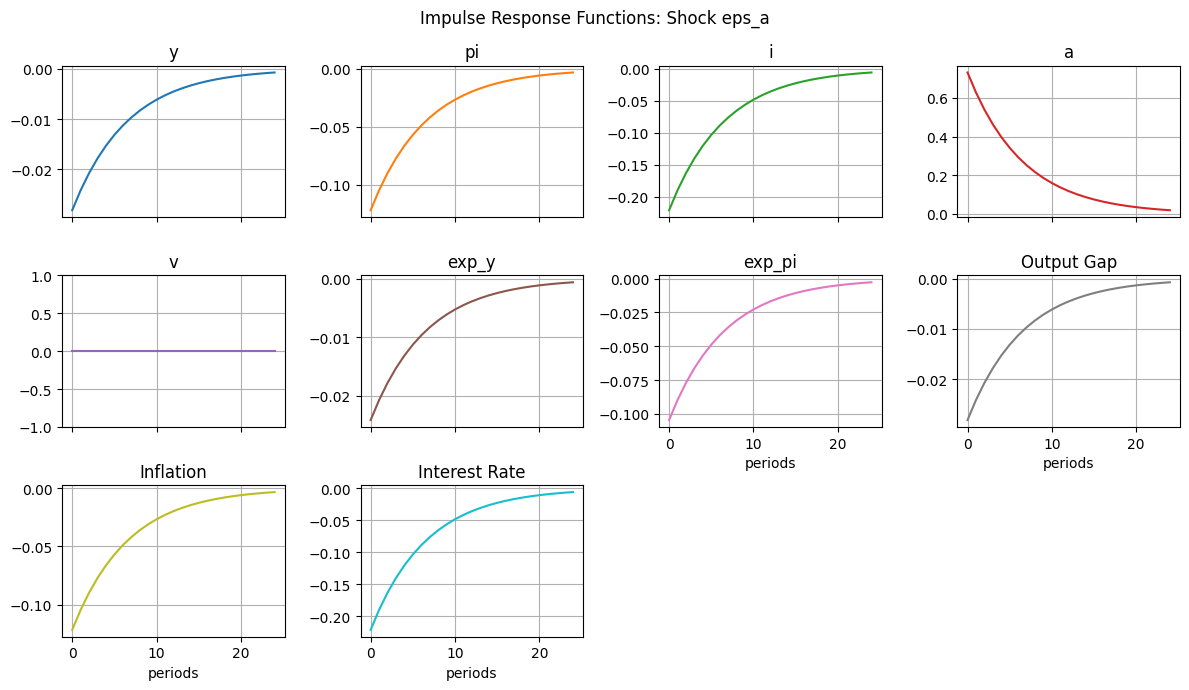

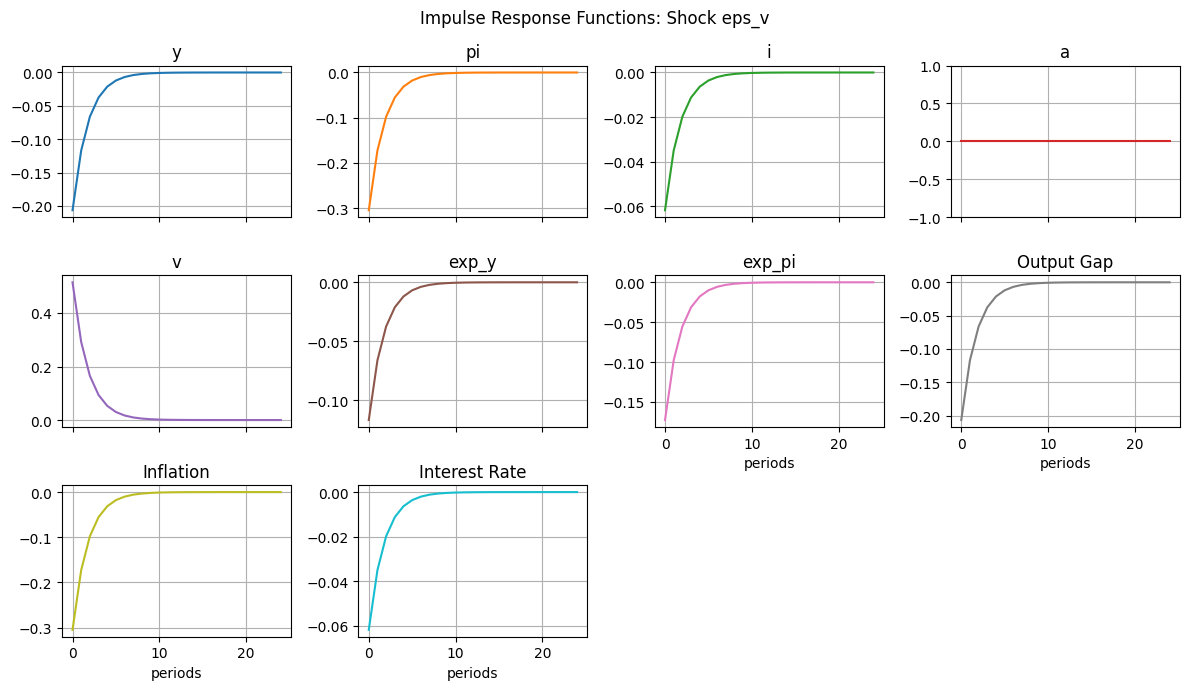

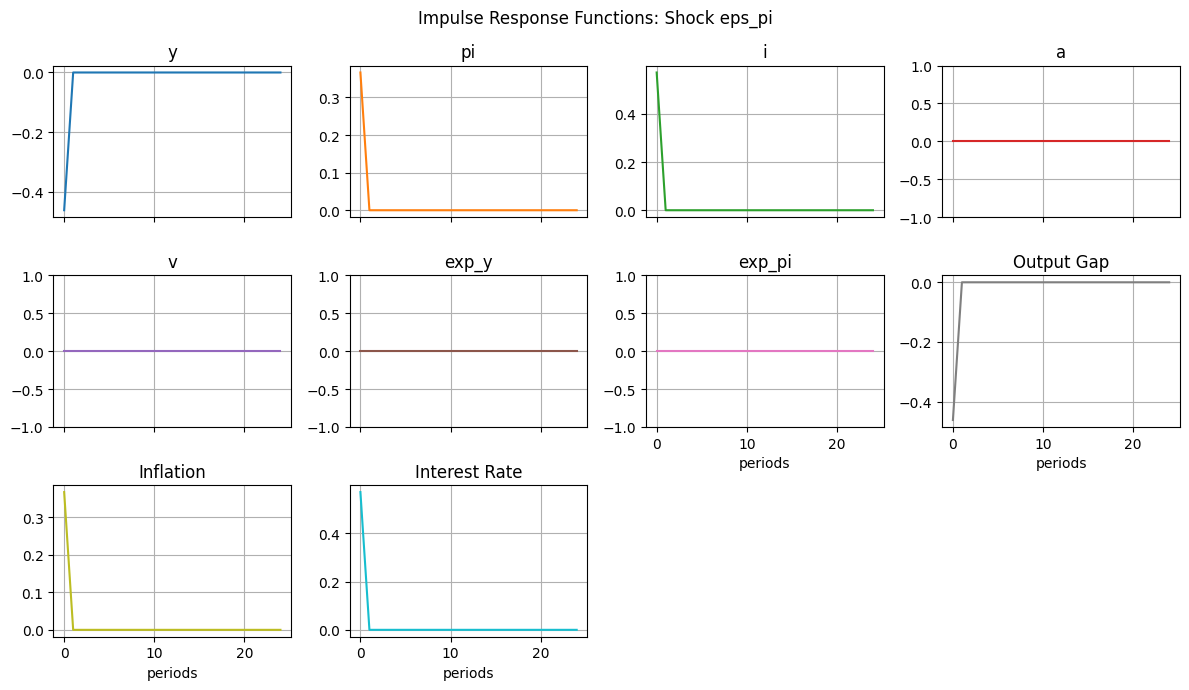

Computing historical decomposition: 100it [00:00, 871.39it/s]


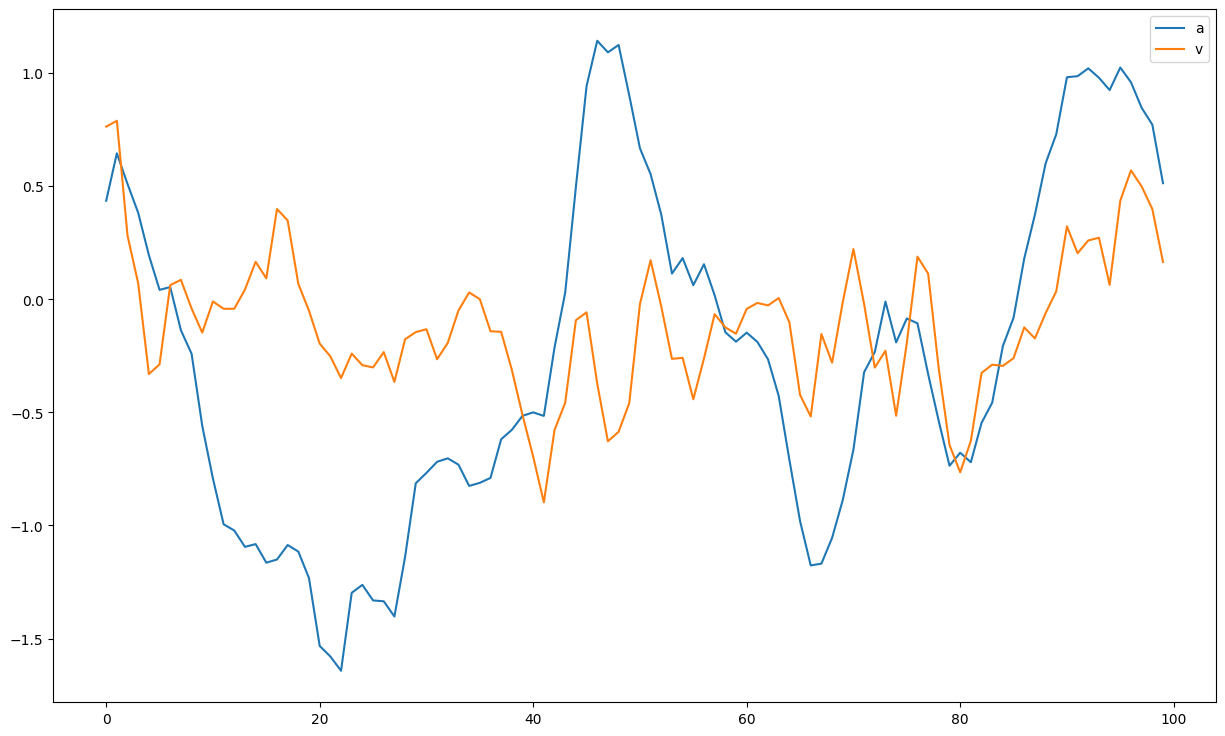

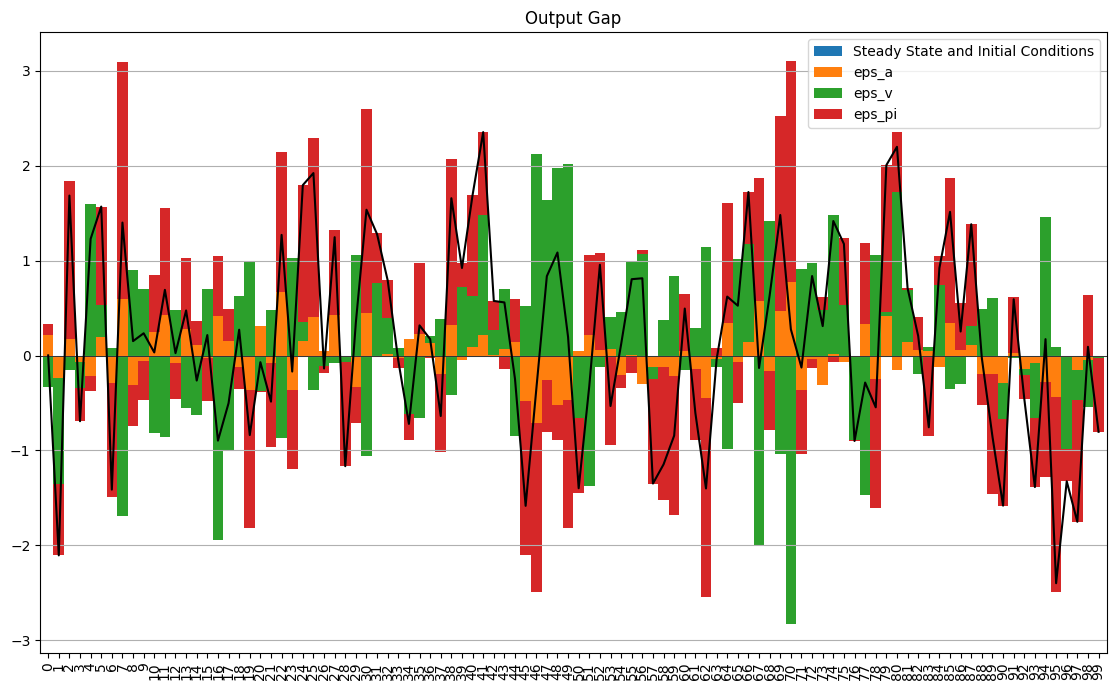

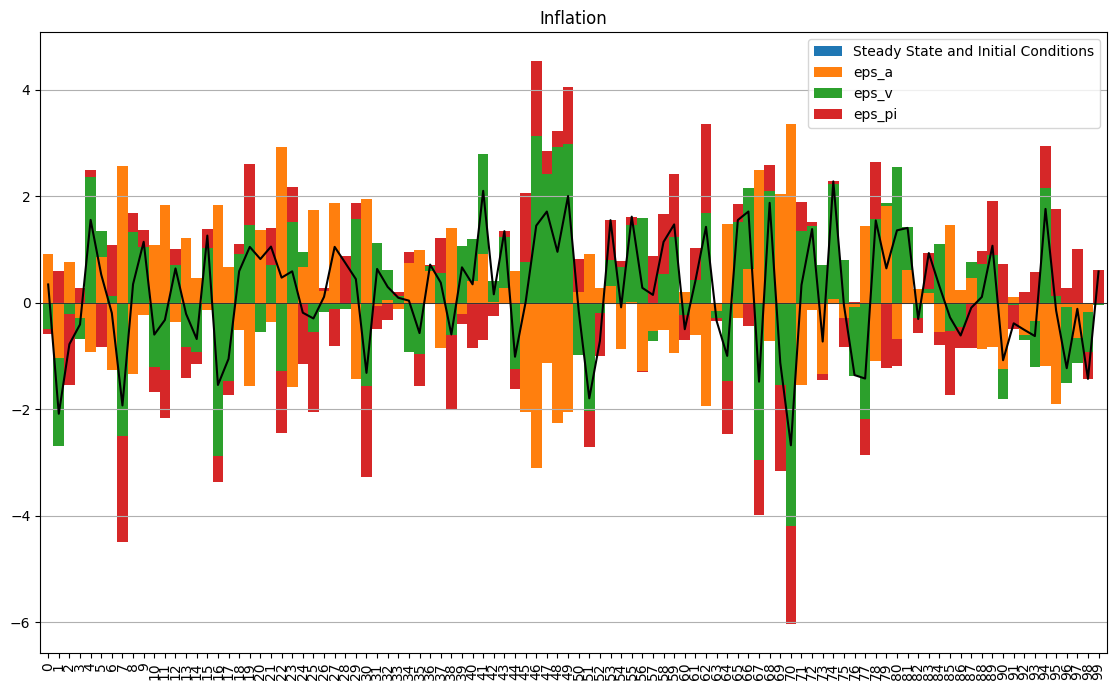

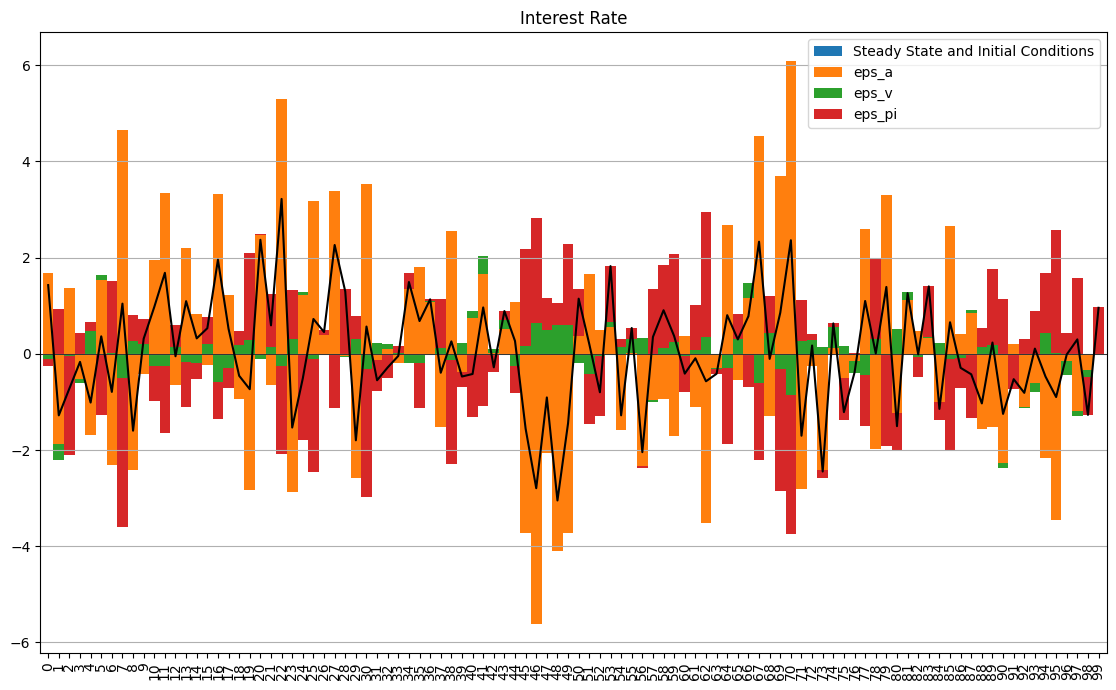

Steady State and Initial Conditions     eps_a     eps_v  \
Output Gap    0                         -4.163336e-17  0.212774 -0.328571   
              1                         -4.440892e-16 -0.238801  -1.11609   
              2                          4.440892e-16  0.175353 -0.148485   
              3                         -1.110223e-16 -0.066889 -0.270924   
              4                         -2.220446e-16 -0.214295  1.598736   
...                                               ...       ...       ...   
Interest Rate 95                         8.881784e-16 -3.464348  0.027337   
              96                         5.551115e-17 -0.154408 -0.287465   
              97                        -1.110223e-16 -1.185932 -0.096618   
              98                         0.000000e+00  -0.33194  -0.15019   
              99                         8.881784e-16 -0.006162 -0.006144   

                    eps_pi  
Output Gap    0    0.11727  
              1  -0.752211  
              2   1.659577  
              3  -0.354742  
              4  -0.155127  
...                    ...  
Interest Rate 95  2.538492  
              96  0.427348  
              97  1.582976  
              98 -0.787614  
              99  0.969045  

[300 rows x 4 columns]

In [7]:
# ============================================================================
# SECTION 5: DSGE MODEL SIMULATION AND ESTIMATION
# ============================================================================
 
# Simulate data for estimation
df_obs_sim, df_states = model.simulate(n_obs=200, random_seed=1)
# Use last 100 obs
df_obs_sim = df_obs_sim.tail(100).reset_index(drop=True)

# PARAMETER SETUP FOR ESTIMATION
calib_param = {
    varphi: 2.0,       # More realistic Frisch elasticity
    alpha: 0.33,       # Standard capital share
    beta: 0.99         # Standard discount factor
}
estimate_param = Matrix([
    sigma,     # Risk aversion
    theta,     # Price stickiness
    phi_pi,    # Taylor rule: inflation
    phi_y,     # Taylor rule: output
    rho_a,     # TFP shock persistence
    sigma_a,   # TFP shock volatility
    rho_v,     # Monetary shock persistence
    sigma_v,   # Monetary shock volatility
    sigma_pi   # Cost-push shock volatility
])

# Prior dictionary
prior_dict = {
    sigma:    {'dist': 'normal',   'mean':  1.30, 'std': 0.20, 'label': '$\\sigma$'},
    theta:    {'dist': 'beta',     'mean':  theta_target, 'std': 0.10, 'label': '$\\theta$'},
    phi_pi:   {'dist': 'normal',   'mean':  1.50, 'std': 0.35, 'label': '$\\phi_{\\pi}$'},
    phi_y:    {'dist': 'gamma',    'mean':  0.25, 'std': 0.10, 'label': '$\\phi_{y}$'},
    rho_a:    {'dist': 'beta',     'mean':  0.50, 'std': 0.25, 'label': '$\\rho_a$'},
    sigma_a:  {'dist': 'invgamma', 'mean':  0.50, 'std': 0.25, 'label': '$\\sigma_a$'},
    rho_v:    {'dist': 'beta',     'mean':  0.50, 'std': 0.25, 'label': '$\\rho_v$'},
    sigma_v:  {'dist': 'invgamma', 'mean':  0.50, 'std': 0.25, 'label': '$\\sigma_v$'},
    sigma_pi: {'dist': 'invgamma', 'mean':  0.50, 'std': 0.25, 'label': '$\\sigma_{\\pi}$'}
}

# Reinstantiate for estimation
dsge = DSGE(
    endog=endog,
    endogl=endogl,
    exog=exog,
    expec=expec,
    state_equations=equations,
    estimate_params=estimate_param,
    calib_dict=calib_param,
    obs_equations=obs_equations,
    prior_dict=prior_dict,
    obs_data=df_obs_sim,  # Using simulated data
    obs_names=['Output Gap', 'Inflation', 'Interest Rate'],         
    verbose=True
)

# Run estimation
dsge.estimate(file_path='example_snkm.pkl', nsim=2000, ck=0.5)

# Evaluate chains and view posterior table
dsge.eval_chains(burnin=0.1, show_charts=True)
print(dsge.posterior_table)

# IRFs and historical decomposition
dsge.irf(periods=24, show_charts=True)
df_states_hat, df_states_se = dsge.states()
df_states_hat[['a', 'v']].plot(figsize=(15, 9))
dsge.hist_decomp(show_charts=True)

Metropolis-Hastings: 100%|██████████| 1999/1999 [03:10<00:00, 10.48it/s]


Acceptance rate: 45.7 percent


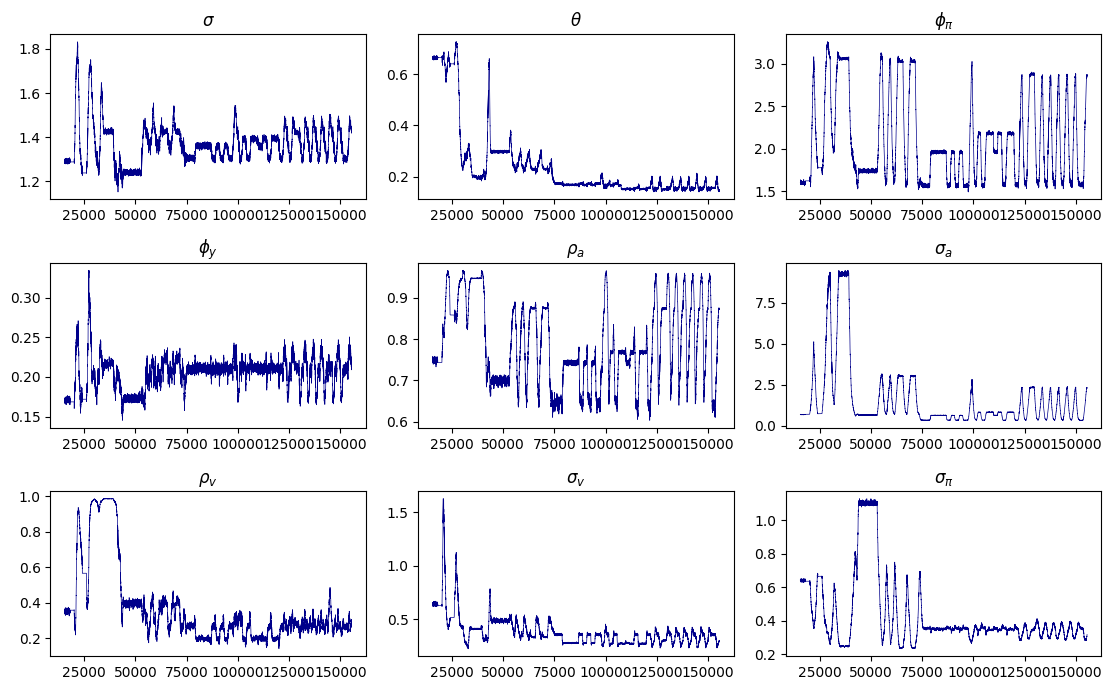

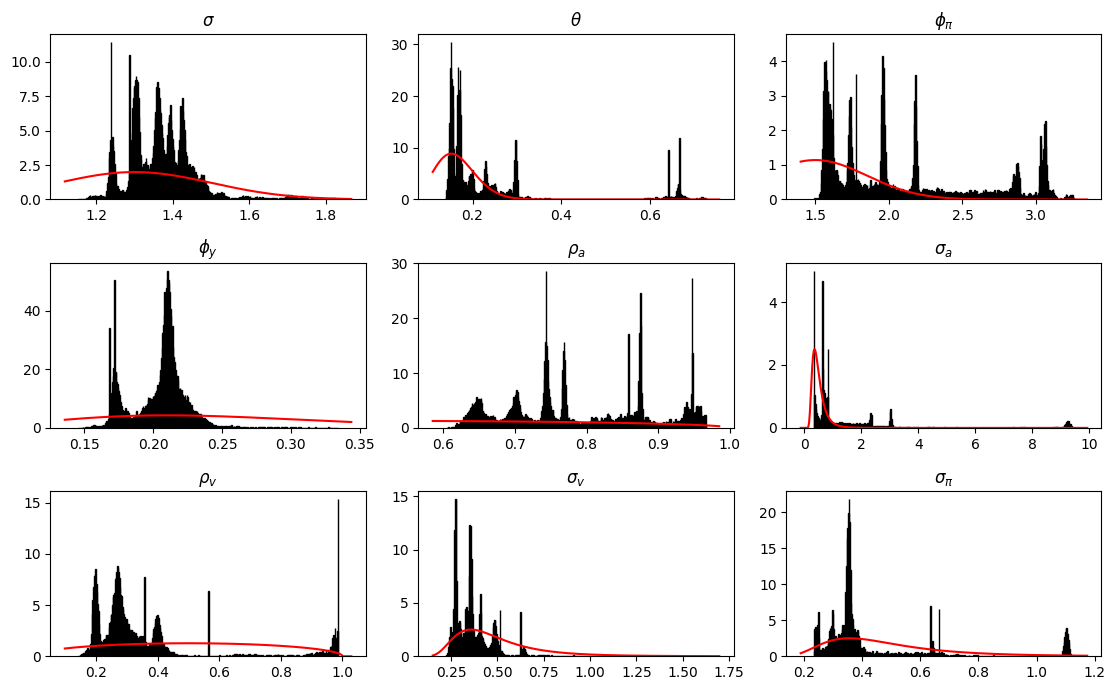

         prior dist prior mean prior std  posterior mode  posterior mean  \
sigma        normal        1.3       0.2        1.237633        1.367203   
theta          beta   0.837091       0.1        0.640577        0.242183   
phi_pi       normal        1.5      0.35        1.774790        2.088937   
phi_y         gamma       0.25       0.1        0.171834        0.204518   
rho_a          beta        0.5      0.25        0.858850        0.788559   
sigma_a    invgamma        0.5      0.25        0.731159        1.593564   
rho_v          beta        0.5      0.25        0.566325        0.373088   
sigma_v    invgamma        0.5      0.25        0.514623        0.381687   
sigma_pi   invgamma        0.5      0.25        0.665799        0.432791   

          posterior 5.0%  posterior 95.0%  
sigma           1.237633         1.499099  
theta           0.148423         0.661233  
phi_pi          1.561965         3.058345  
phi_y           0.170144         0.232807  
rho_a           0.6

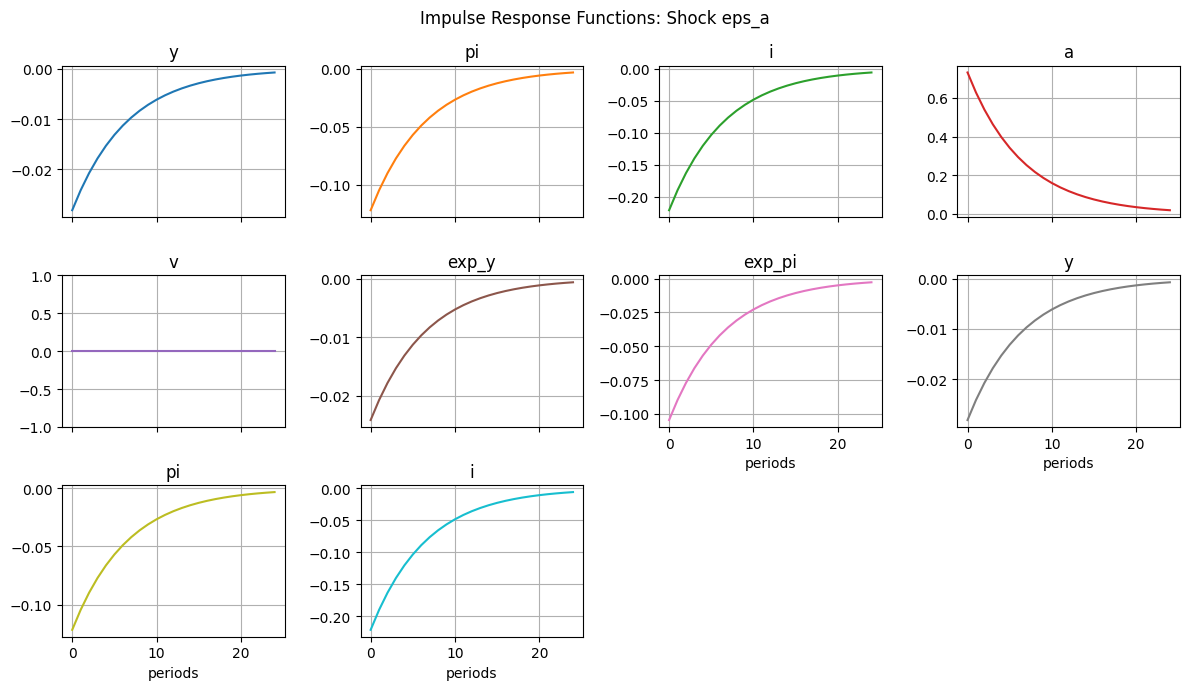

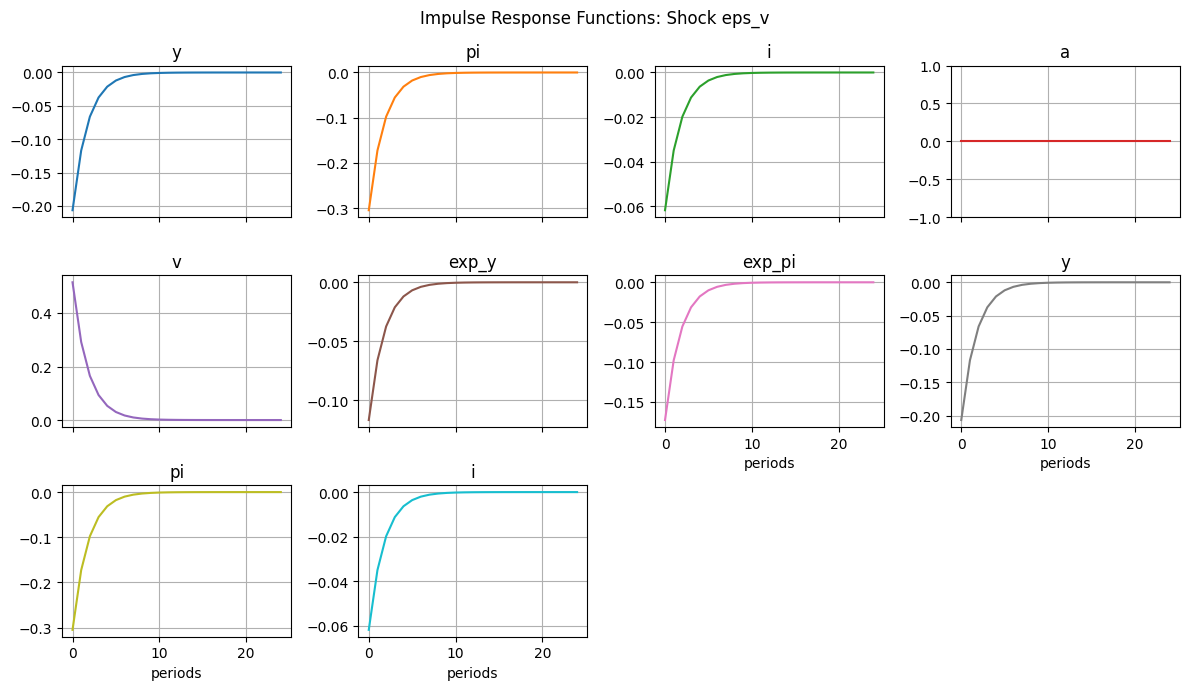

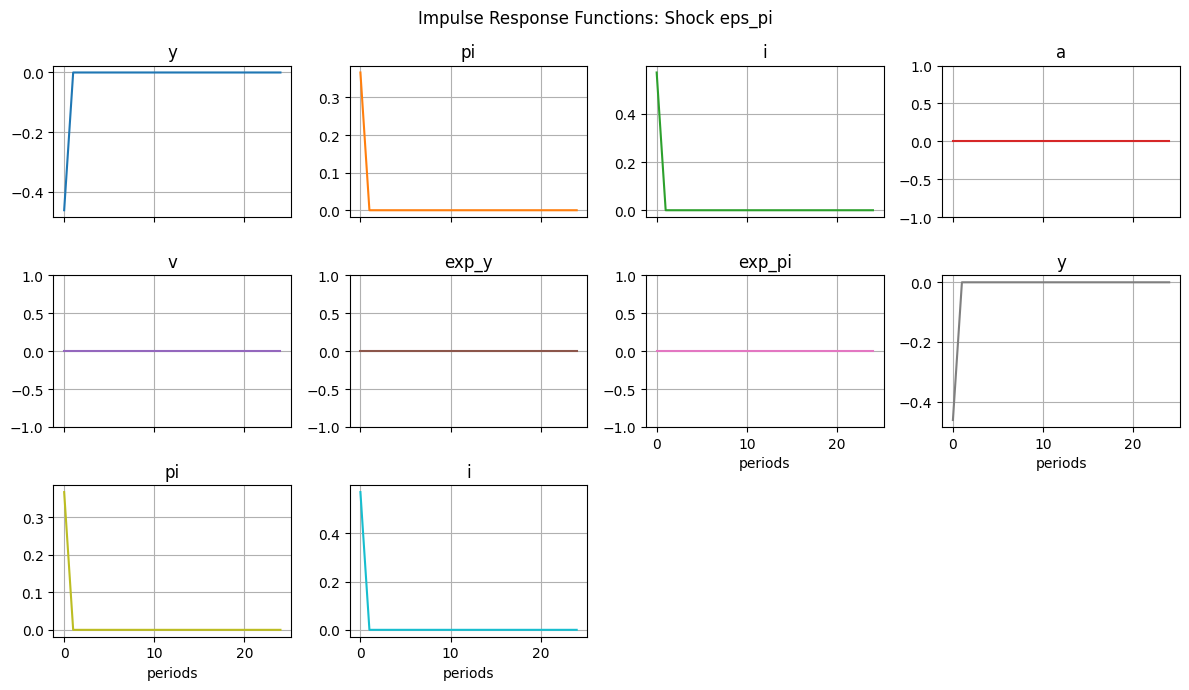

Computing historical decomposition: 141it [00:00, 565.19it/s]


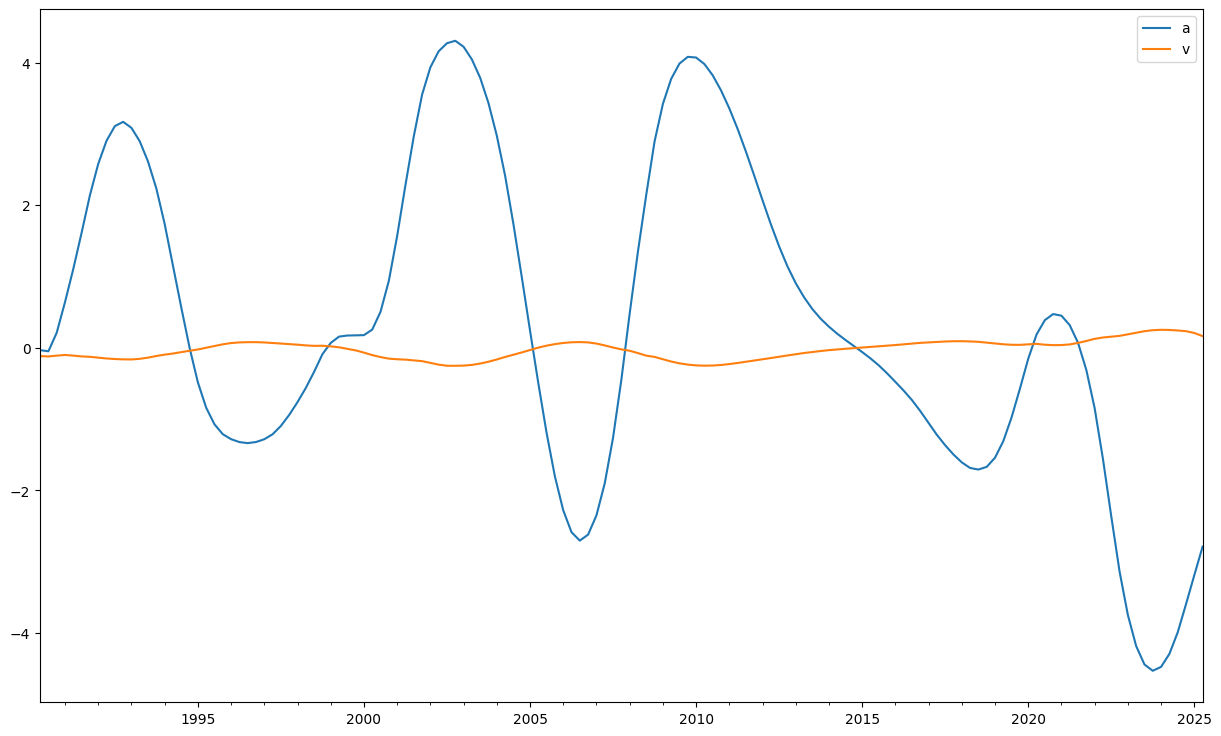

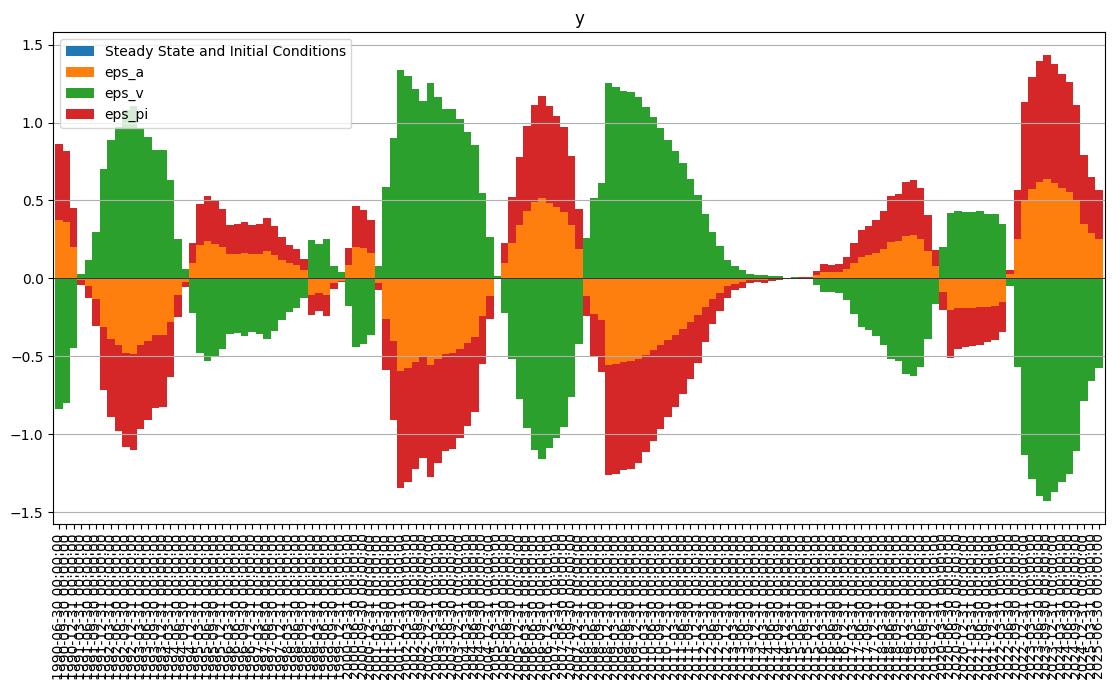

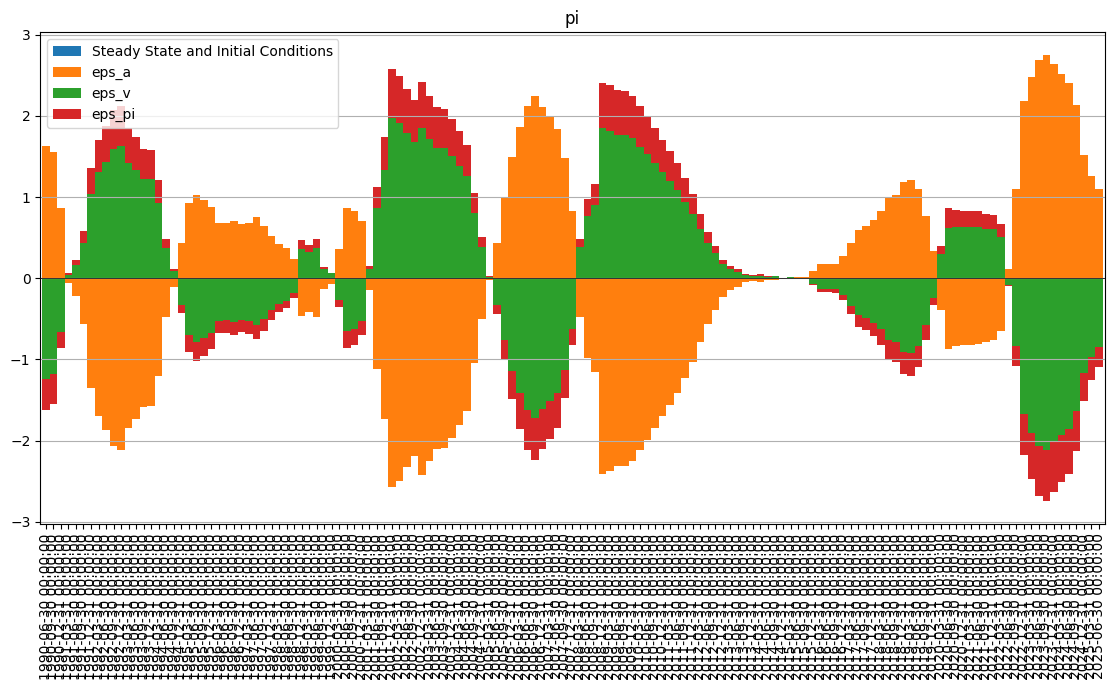

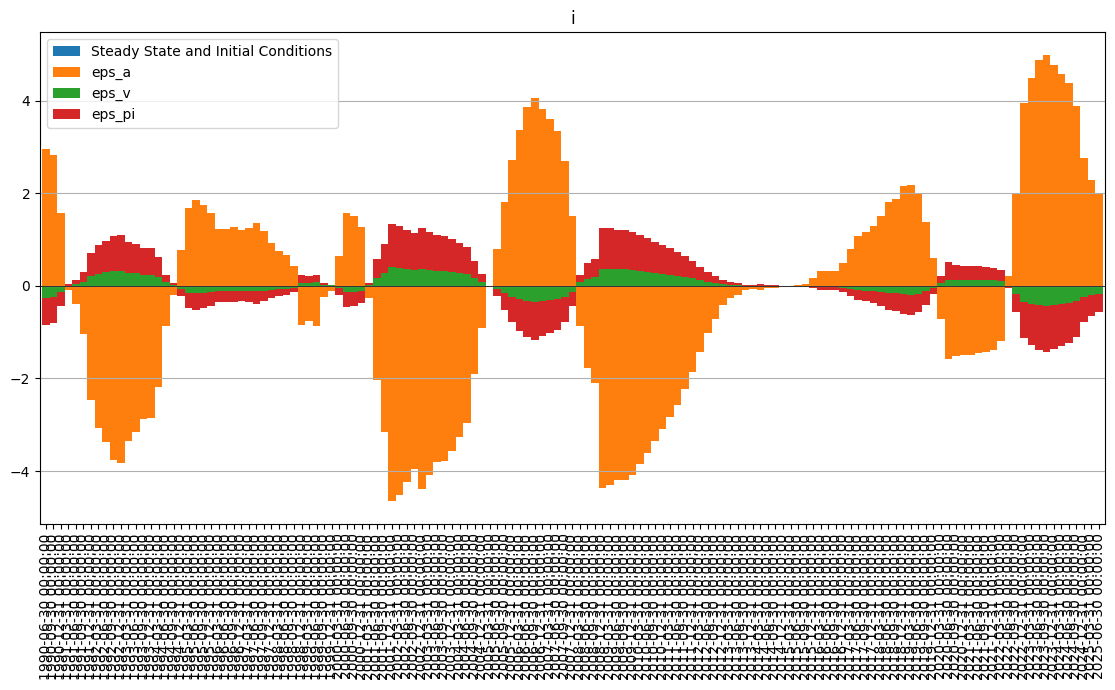

Steady State and Initial Conditions     eps_a     eps_v  \
y 1990-06-30                        -2.775558e-16    0.3775 -0.839964   
  1990-09-30                        -5.551115e-17  0.360531 -0.802225   
  1990-12-31                        -1.110223e-16   0.20094 -0.448871   
  1991-03-31                        -2.151057e-16 -0.012217   0.02982   
  1991-06-30                        -9.714451e-17 -0.050571  0.115076   
...                                           ...       ...       ...   
i 2024-06-30                        -4.440892e-16  4.374975 -0.375019   
  2024-09-30                         0.000000e+00   3.87794 -0.331849   
  2024-12-31                        -4.440892e-16  2.764928 -0.236284   
  2025-03-31                        -4.440892e-16  2.290919 -0.196433   
  2025-06-30                        -6.661338e-16  1.995914 -0.171199   

                eps_pi  
y 1990-06-30  0.482427  
  1990-09-30  0.456531  
  1990-12-31  0.247792  
  1991-03-31  -0.02834  
  1991-06-30 -0.073493  
...                ...  
i 2024-06-30 -0.866455  
  2024-09-30 -0.767091  
  2024-12-31 -0.546143  
  2025-03-31 -0.445986  
  2025-06-30 -0.388715  

[423 rows x 4 columns]

In [8]:
## ESTIMATION SECTION ##
# Use actual observed data (not simulated)
df_obs = data[['y', 'pi', 'i']].copy()

# Ensure the shape matches expected observables (3 variables)
assert df_obs.shape[1] == 3, "Your observed data must have exactly 3 variables: y, pi, and i."

# CORRECTED PARAMETER SETUP (Method 1: Keep theta estimated)
calib_param = {
    varphi: 2.0,       # FIXED: More realistic Frisch elasticity
    alpha: 0.33,       # FIXED: Standard capital share
    beta: 0.99         # FIXED: Standard discount factor
}
estimate_param = Matrix([
    sigma,     # Risk aversion
    theta,     # Price stickiness
    phi_pi,    # Taylor rule: inflation
    phi_y,     # Taylor rule: output
    rho_a,     # TFP shock persistence
    sigma_a,   # TFP shock volatility
    rho_v,     # Monetary shock persistence
    sigma_v,   # Monetary shock volatility
    sigma_pi   # Cost-push shock volatility
])

# Priors for Bayesian estimation
prior_dict = {
    sigma:    {'dist': 'normal',   'mean':  1.30, 'std': 0.20, 'label': '$\\sigma$'},
    theta:    {'dist': 'beta',     'mean':  theta_target, 'std': 0.10, 'label': '$\\theta$'},  # Centered at value that implies target kappa
    phi_pi:   {'dist': 'normal',   'mean':  1.50, 'std': 0.35, 'label': '$\\phi_{\\pi}$'},
    phi_y:    {'dist': 'gamma',    'mean':  0.25, 'std': 0.10, 'label': '$\\phi_{y}$'},
    rho_a:    {'dist': 'beta',     'mean':  0.50, 'std': 0.25, 'label': '$\\rho_a$'},
    sigma_a:  {'dist': 'invgamma', 'mean':  0.50, 'std': 0.25, 'label': '$\\sigma_a$'},
    rho_v:    {'dist': 'beta',     'mean':  0.50, 'std': 0.25, 'label': '$\\rho_v$'},
    sigma_v:  {'dist': 'invgamma', 'mean':  0.50, 'std': 0.25, 'label': '$\\sigma_v$'},
    sigma_pi: {'dist': 'invgamma', 'mean':  0.50, 'std': 0.25, 'label': '$\\sigma_{\\pi}$'}
}

# Instantiate the DSGE model
dsge = DSGE(
    endog=endog,
    endogl=endogl,
    exog=exog,
    expec=expec,
    state_equations=equations,
    estimate_params=estimate_param,
    calib_dict=calib_param,
    obs_equations=obs_equations,
    prior_dict=prior_dict,
    obs_data=df_obs,                    # Using improved data
    obs_names=['y', 'pi', 'i'],         
    verbose=True
)

# Run estimation
dsge.estimate(file_path='example_snkm.pkl', nsim=2000, ck=0.5)

# Diagnostics
dsge.eval_chains(burnin=0.1, show_charts=True)
print(dsge.posterior_table)

# Impulse Response Functions (IRFs)
dsge.irf(periods=24, show_charts=True)

# Estimated states and historical decomposition
df_states_hat, df_states_se = dsge.states()
df_states_hat[['a', 'v']].plot(figsize=(15, 9))
dsge.hist_decomp(show_charts=True)

In [30]:
# ============================================================================
# SECTION 6: FORECASTING FUNCTIONS
# ============================================================================

def verify_data_alignment(obs_data, raw_data):
    """
    Critical diagnostic: Verify that gap + trend = observed level
    """
    print(f"\n=== DATA ALIGNMENT VERIFICATION ===")
    
    # Check if we have matching dates
    common_dates = obs_data.index.intersection(raw_data.index)
    print(f"Common dates: {len(common_dates)} out of {len(obs_data)} obs_data points")
    
    if len(common_dates) == 0:
        print("❌ ERROR: No matching dates between obs_data and raw_data!")
        return False
    
    # Get the last common date
    last_common_date = common_dates[-1]
    print(f"Last common date: {last_common_date}")
    
    # Extract values at last common date
    last_gap = obs_data.loc[last_common_date, 'i']
    last_raw = raw_data.loc[last_common_date, 'fed']
    
    print(f"At {last_common_date}:")
    print(f"  Interest rate gap (obs_data): {last_gap:.6f}")
    print(f"  Raw interest rate (raw_data): {last_raw:.6f}")
    
    # Calculate implied trend
    implied_trend = last_raw - last_gap
    print(f"  Implied trend: {implied_trend:.6f}")
    
    # Verify reconstruction
    reconstructed_rate = implied_trend + last_gap
    error = abs(reconstructed_rate - last_raw)
    print(f"  Reconstruction check: {reconstructed_rate:.6f}")
    print(f"  Reconstruction error: {error:.8f}")
    
    if error > 1e-6:
        print(f"❌ WARNING: Large reconstruction error ({error:.8f})")
        return False
    else:
        print(f"✅ Data alignment verified (error: {error:.8f})")
        return True

def generate_forecast_base(obs_data, raw_data, forecast_horizon, n_simulations, method_name, forecast_func):
    """
    Base function for generating forecasts with common structure.
    """
    print(f"Generating {method_name} forecasts for {forecast_horizon} periods...")
    
    # CRITICAL: Verify data alignment first
    if not verify_data_alignment(obs_data, raw_data):
        print("❌ Cannot proceed with forecasting due to data alignment issues")
        return None
    
    # Find last common date to ensure perfect alignment
    common_dates = obs_data.index.intersection(raw_data.index)
    last_common_date = common_dates[-1]
    
    # Use values from the same date
    last_obs_gaps = obs_data.loc[last_common_date].values
    last_observed_rate = raw_data.loc[last_common_date, 'fed']
    last_observed_gap = obs_data.loc[last_common_date, 'i']
    
    # Generate gap forecasts using the specific method function
    all_forecasts_gaps = forecast_func(obs_data, last_obs_gaps, forecast_horizon, n_simulations)
    
    point_forecast_gaps = np.mean(all_forecasts_gaps, axis=0)
    
    # CRITICAL FIX: Use exact same-date values for perfect continuity
    implied_trend_last = last_observed_rate - last_observed_gap
    
    # Apply to all simulations for proper confidence bands
    all_forecasts_raw_i = implied_trend_last + all_forecasts_gaps[:, :, 2]
    point_forecast_raw_i = np.mean(all_forecasts_raw_i, axis=0)
    
    # Continuity verification
    first_forecast_rate = implied_trend_last + point_forecast_gaps[0, 2]
    continuity_error = abs(first_forecast_rate - last_observed_rate)
    
    print(f"🔍 FORECAST CONTINUITY CHECK:")
    print(f"   Using date: {last_common_date}")
    print(f"   Last observed rate: {last_observed_rate:.6f}")
    print(f"   First forecast rate: {first_forecast_rate:.6f}")
    print(f"   Continuity error: {continuity_error:.8f}")
    
    if continuity_error > 1e-6:
        print(f"❌ WARNING: Continuity error too large: {continuity_error:.8f}")
    else:
        print(f"✅ Perfect continuity achieved!")
    
    # Confidence bands using percentiles
    confidence_bands = {}
    for conf_level in [0.90]:
        lower_pct, upper_pct = 100 * (1-conf_level)/2, 100 * (1-(1-conf_level)/2)
        
        confidence_bands[conf_level] = {
            'lower_gaps': np.percentile(all_forecasts_gaps, lower_pct, axis=0),
            'upper_gaps': np.percentile(all_forecasts_gaps, upper_pct, axis=0),
            'lower_raw_i': np.percentile(all_forecasts_raw_i, lower_pct, axis=0),
            'upper_raw_i': np.percentile(all_forecasts_raw_i, upper_pct, axis=0)
        }
    
    return {
        'point_forecast_gaps': point_forecast_gaps,
        'point_forecast_raw_i': point_forecast_raw_i,
        'confidence_bands': confidence_bands,
        'method': method_name
    }

def model_pure_forecast_logic(obs_data, last_obs_gaps, forecast_horizon, n_simulations):
    """Pure DSGE model forecasting logic"""
    hist_data = obs_data.values
    
    # Calculate reversion speeds from data
    reversion_speeds = [max(0.05, min(0.4, 1 - abs(np.corrcoef(hist_data[:-1, i], hist_data[1:, i])[0, 1]))) 
                       if len(hist_data) > 1 else 0.2 for i in range(3)]
    
    # Economic theory targets
    y_target, pi_target, i_target = 0.0, 0.005, 0.0
    
    # Generate gap forecasts
    all_forecasts_gaps = np.zeros((n_simulations, forecast_horizon, 3))
    
    for sim in range(n_simulations):
        forecast = np.zeros((forecast_horizon, 3))
        current_state = last_obs_gaps.copy()
        
        # First forecast point must be the last observed point
        forecast[0] = current_state.copy()
        
        for t in range(1, forecast_horizon):
            # Normal reversion from second period onward
            current_state[0] += reversion_speeds[0] * (y_target - current_state[0])
            current_state[1] += reversion_speeds[1] * (pi_target - current_state[1])
            current_state[2] += reversion_speeds[2] * (i_target - current_state[2])
            
            forecast[t] = current_state.copy()
        
        all_forecasts_gaps[sim] = forecast
    
    return all_forecasts_gaps

# ============================================================================
# ENHANCED DATA INGESTION WITH SHOCK PROXIES
# ============================================================================

def download_shock_proxies(fred, start, end):
    """Download and prepare shock proxy variables from FRED"""
    print("📥 Downloading shock proxy variables...")
    
    shock_proxies = {
        # Supply shock proxies
        'oil_price': fred.get_series('DCOILWTICO', start, end),          # Oil prices
        'commodity_price': fred.get_series('PPIACO', start, end),        # Producer price index
        
        # Demand shock proxies  
        'consumer_sentiment': fred.get_series('UMCSENT', start, end),    # Consumer sentiment
        'credit_spread': None,  # Will calculate as BAA-10Y spread
        
        # Monetary policy shock proxies
        'term_spread': None,    # Will calculate as 10Y-3M spread
        'real_rate': None,      # Will calculate as Fed Funds - inflation
        
        # Additional series needed for calculations
        'baa_yield': fred.get_series('BAA', start, end),                 # Corporate bond yield
        'treasury_10y': fred.get_series('DGS10', start, end),           # 10-year treasury
        'treasury_3m': fred.get_series('DGS3MO', start, end),           # 3-month treasury
    }
    
    # Convert to DataFrame and resample to quarterly
    shock_df = pd.DataFrame(shock_proxies).resample('Q-DEC').last()
    
    # Calculate derived shock proxies
    shock_df['credit_spread'] = shock_df['baa_yield'] - shock_df['treasury_10y']
    shock_df['term_spread'] = shock_df['treasury_10y'] - shock_df['treasury_3m']
    
    # Clean up - keep only the proxy variables we need
    shock_proxies_final = shock_df[['oil_price', 'commodity_price', 'consumer_sentiment', 
                                   'credit_spread', 'term_spread']].copy()
    
    print(f"Shock proxies shape: {shock_proxies_final.shape}")
    return shock_proxies_final

# ============================================================================
# HELPER FUNCTIONS (MUST BE DEFINED BEFORE MAIN FUNCTION)
# ============================================================================

def estimate_shock_relationships(obs_data, shock_proxies):
    """Estimate how shock proxies relate to structural innovations"""
    
    # Align datasets
    common_idx = obs_data.index.intersection(shock_proxies.index)
    obs_aligned = obs_data.loc[common_idx]
    shocks_aligned = shock_proxies.loc[common_idx]
    
    if len(common_idx) < 20:
        print(f"⚠️  Warning: Only {len(common_idx)} common observations for shock estimation")
        return None
        
    # Calculate structural residuals (innovations)
    residuals = {}
    for i, var in enumerate(['y', 'pi', 'i']):
        series = obs_aligned.iloc[:, i].values
        if len(series) > 1:
            # Simple AR(1) residuals
            y_lag = series[:-1]
            y_curr = series[1:]
            if np.var(y_lag) > 1e-8:
                beta = np.sum((y_lag - np.mean(y_lag)) * (y_curr - np.mean(y_curr))) / np.sum((y_lag - np.mean(y_lag))**2)
                residuals[var] = y_curr - (np.mean(y_curr) + beta * (y_lag - np.mean(y_lag)))
            else:
                residuals[var] = y_curr - np.mean(y_curr)
        else:
            residuals[var] = np.array([0.0])
    
    # Match residuals with shock proxies (drop first observation for residuals)
    shock_relationships = {}
    for var in ['y', 'pi', 'i']:
        if len(residuals[var]) > 0:
            # Align with shock proxies (accounting for the dropped first observation)
            shock_idx = shocks_aligned.index[1:1+len(residuals[var])]
            if len(shock_idx) == len(residuals[var]):
                shock_subset = shocks_aligned.loc[shock_idx]
                
                # Estimate relationships via simple correlation/regression
                relationships = {}
                for shock_var in shock_subset.columns:
                    if shock_subset[shock_var].notna().sum() > 10:
                        corr = np.corrcoef(residuals[var], shock_subset[shock_var].fillna(0))[0, 1]
                        if not np.isnan(corr):
                            relationships[shock_var] = corr
                        else:
                            relationships[shock_var] = 0.0
                    else:
                        relationships[shock_var] = 0.0
                
                shock_relationships[var] = relationships
            else:
                # Fallback: zero relationships
                shock_relationships[var] = {col: 0.0 for col in shocks_aligned.columns}
        else:
            shock_relationships[var] = {col: 0.0 for col in shocks_aligned.columns}
    
    return shock_relationships

def forecast_shock_proxies(shock_proxies, forecast_horizon):
    """Forecast shock proxy variables using simple time series models"""
    
    forecasted_shocks = {}
    
    for var in shock_proxies.columns:
        series = shock_proxies[var].dropna()
        if len(series) < 10:
            # Insufficient data - use last value with small random variation
            last_val = series.iloc[-1] if len(series) > 0 else 0.0
            forecasted_shocks[var] = np.full(forecast_horizon, last_val)
            continue
        
        # Simple AR(1) model for each shock proxy
        y = series.values[1:]
        x = series.values[:-1]
        
        if np.var(x) > 1e-8:
            # Estimate AR(1) parameters
            beta = np.sum((x - np.mean(x)) * (y - np.mean(y))) / np.sum((x - np.mean(x))**2)
            alpha = np.mean(y) - beta * np.mean(x)
            residual_std = np.std(y - (alpha + beta * x))
            
            # Forecast
            forecast = np.zeros(forecast_horizon)
            last_val = series.iloc[-1]
            
            for t in range(forecast_horizon):
                if t == 0:
                    forecast[t] = alpha + beta * last_val
                    last_val = forecast[t]
                else:
                    forecast[t] = alpha + beta * last_val
                    last_val = forecast[t]
            
            forecasted_shocks[var] = forecast
        else:
            # Constant forecast
            forecasted_shocks[var] = np.full(forecast_horizon, np.mean(series))
    
    return forecasted_shocks

In [31]:
# ============================================================================
# SECTION 7: PLOTTING AND DIAGNOSTIC FUNCTIONS
# ============================================================================

def diagnose_data_issues(obs_data, raw_data):
    """
    Diagnostic function to identify potential data issues before plotting.
    """
    print("=== DATA DIAGNOSTICS ===")
    print(f"obs_data shape: {obs_data.shape}")
    print(f"obs_data columns: {list(obs_data.columns)}")
    print(f"obs_data index type: {type(obs_data.index)}")
    
    if hasattr(obs_data, 'index') and len(obs_data.index) > 0:
        print(f"obs_data date range: {obs_data.index[0]} to {obs_data.index[-1]}")
        print(f"obs_data frequency: {pd.infer_freq(obs_data.index)}")
    else:
        print("obs_data has no proper date index!")
        
    print(f"\nraw_data date range: {raw_data.index[0]} to {raw_data.index[-1]}")
    print(f"raw_data frequency: {pd.infer_freq(raw_data.index)}")
    
    # Check for data alignment
    if hasattr(obs_data, 'index'):
        if obs_data.index[0] != raw_data.index[0]:
            print(f"WARNING: Date range mismatch!")
            print(f"  obs_data starts: {obs_data.index[0]}")
            print(f"  raw_data starts: {raw_data.index[0]}")
    
    # Check for missing values
    print(f"\nMissing values in obs_data: {obs_data.isnull().sum().sum()}")
    print(f"Missing values in raw_data: {raw_data.isnull().sum().sum()}")
    
    print("=== END DIAGNOSTICS ===\n")

def plot_forecast_comparison_all(obs_data, raw_data, forecasts_v1, forecasts_v2, forecasts_v3, forecast_horizon):
    """
    Plots the comparison of three different forecasts against the observed data.
    """
    # Debug information
    print(f"Data debugging:")
    print(f"  obs_data index type: {type(obs_data.index)}")
    print(f"  obs_data date range: {obs_data.index[0]} to {obs_data.index[-1]}")
    print(f"  raw_data date range: {raw_data.index[0]} to {raw_data.index[-1]}")
    print(f"  Inferred frequency: {pd.infer_freq(obs_data.index)}")
    
    # Variable labels
    variable_labels = {
        'y': 'Output Gap',
        'pi': 'Inflation',
        'i': 'Interest Rate'
    }

    colors_v1, colors_v2, colors_v3 = 'red', 'green', 'blue'
    labels_v1, labels_v2, labels_v3 = 'Model Pure DSGE', 'Theory Free', 'DSGE Style'
    
    # Get the list of variables to plot
    variable_names = list(obs_data.columns)
    
    # Create the plots
    num_plots = len(variable_names)
    fig, axes = plt.subplots(num_plots, 1, figsize=(15, 6 * num_plots), sharex=True)
    if num_plots == 1:
        axes = [axes]
        
    for i, var_name in enumerate(variable_names):
        ax = axes[i]
        
        # Ensure proper title mapping
        plot_title = variable_labels.get(var_name, var_name)
        print(f"Plotting variable: '{var_name}' as '{plot_title}'")
        
        # Plot historical data
        ax.plot(obs_data.index, obs_data[var_name], label='Observed Data', color='grey', linewidth=1.5)
        
        # Use consistent frequency with the data
        data_freq = pd.infer_freq(obs_data.index)
        if data_freq is None:
            # Fallback: determine frequency from index spacing
            if len(obs_data.index) > 1:
                delta = obs_data.index[1] - obs_data.index[0]
                if delta.days > 250:  # Likely annual
                    data_freq = 'A'
                elif delta.days > 80:  # Likely quarterly
                    data_freq = 'Q'
                else:  # Likely monthly
                    data_freq = 'M'
            else:
                data_freq = 'Q'  # Default fallback
        
        print(f"Using frequency: {data_freq}")
        forecast_dates = pd.date_range(start=obs_data.index[-1], periods=forecast_horizon + 1, freq=data_freq)[1:]
        
        last_date = obs_data.index[-1]
        last_hist_value = obs_data[var_name].iloc[-1]
        
        # Extract forecast data based on variable type
        if var_name == 'i':
            forecast_data_v1 = forecasts_v1['point_forecast_raw_i']
            forecast_data_v2 = forecasts_v2['point_forecast_raw_i']
            forecast_data_v3 = forecasts_v3['point_forecast_raw_i']
            first_vals = [forecast_data_v1[0], forecast_data_v2[0], forecast_data_v3[0]]
        else:
            forecast_data_v1 = forecasts_v1['point_forecast_gaps'][:, i]
            forecast_data_v2 = forecasts_v2['point_forecast_gaps'][:, i]
            forecast_data_v3 = forecasts_v3['point_forecast_gaps'][:, i]
            first_vals = [forecast_data_v1[0], forecast_data_v2[0], forecast_data_v3[0]]
        
        print(f"Last observed {var_name}: {last_hist_value:.4f}")
        print(f"First forecast values: {[f'{val:.4f}' for val in first_vals]}")
        
        # Improved date conversion for connecting lines
        try:
            # Convert to matplotlib dates safely
            if hasattr(last_date, 'to_pydatetime'):
                last_date_num = mdates.date2num(last_date.to_pydatetime())
            else:
                last_date_num = mdates.date2num(last_date)
                
            if hasattr(forecast_dates[0], 'to_pydatetime'):
                first_date_num = mdates.date2num(forecast_dates[0].to_pydatetime())
            else:
                first_date_num = mdates.date2num(forecast_dates[0])
            
            # Plot connecting lines from last observation to first forecast
            colors = [colors_v1, colors_v2, colors_v3]
            for j, (color, first_val) in enumerate(zip(colors, first_vals)):
                ax.plot([last_date_num, first_date_num], [last_hist_value, first_val],
                       color=color, linestyle=':', alpha=0.6, linewidth=1, label='_nolegend_')
        except Exception as e:
            print(f"Warning: Could not plot connecting lines for {var_name}: {e}")
        
        # Plot forecast data
        ax.plot(forecast_dates, forecast_data_v1, color=colors_v1, label=labels_v1, linewidth=2)
        ax.plot(forecast_dates, forecast_data_v2, color=colors_v2, label=labels_v2, linewidth=2)
        ax.plot(forecast_dates, forecast_data_v3, color=colors_v3, label=labels_v3, linewidth=2)
        
        # Improved plot formatting
        ax.set_title(f'Forecast Comparison for {plot_title}', fontsize=14, fontweight='bold')
        ax.set_ylabel(plot_title, fontsize=12)
        ax.grid(True, alpha=0.3)
        
        # Better legend positioning
        ax.legend(loc='upper left', bbox_to_anchor=(0, 1), frameon=True, fancybox=True, shadow=True)
        
        # Format x-axis for better date display
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_major_locator(mdates.YearLocator())
        
    plt.tight_layout()
    plt.show()

In [32]:
# ============================================================================
# SECTION 8: GDP FORECASTING FUNCTIONS
# ============================================================================

def prepare_gdp_data(fred_api_key, start_date='1990-01-01'):
    """
    Fetch and prepare GDP data for forecasting.
    """
    fred = Fred(api_key=fred_api_key)
    end_date = pd.Timestamp.today().strftime('%Y-%m-%d')
    
    # Fetch GDP data
    gdp_real = fred.get_series('GDPC1', start_date, end_date)  # Real GDP
    gdp_nominal = fred.get_series('GDP', start_date, end_date)  # Nominal GDP
    
    # Create DataFrame and handle missing values
    gdp_data = pd.DataFrame({
        'gdp_real': gdp_real,
        'gdp_nominal': gdp_nominal
    }).resample('Q-DEC').last().dropna()
    
    # Calculate log GDP and growth rates
    gdp_data['log_gdp_real'] = np.log(gdp_data['gdp_real'])
    gdp_data['gdp_growth'] = gdp_data['log_gdp_real'].diff() * 100  # Quarterly growth rate (%)
    
    # HP Filter decomposition
    gdp_trend, gdp_gap = hp_filter(gdp_data['log_gdp_real'].values, lambda_hp=1600)
    gdp_data['gdp_trend'] = gdp_trend
    gdp_data['gdp_gap'] = gdp_gap
    
    # Remove initial NaN from differencing
    gdp_data = gdp_data.dropna()
    
    print(f"GDP data prepared from {gdp_data.index[0]} to {gdp_data.index[-1]}")
    print(f"Data shape: {gdp_data.shape}")
    
    return gdp_data

def generate_gdp_forecast_base(gdp_data, forecast_horizon, n_simulations, method_name, forecast_func):
    """
    Base function for GDP forecasting with common structure.
    """
    print(f"Generating {method_name} GDP forecasts for {forecast_horizon} periods...")
    
    # Generate forecasts using the specific method function
    all_forecasts = forecast_func(gdp_data, forecast_horizon, n_simulations)
    
    # Calculate statistics
    point_forecast_log = np.mean(all_forecasts, axis=0)
    point_forecast_level = np.exp(point_forecast_log)
    
    # Confidence bands
    confidence_bands = {}
    for conf_level in [0.68, 0.90]:
        lower_pct = 100 * (1-conf_level)/2
        upper_pct = 100 * (1-(1-conf_level)/2)
        
        lower_log = np.percentile(all_forecasts, lower_pct, axis=0)
        upper_log = np.percentile(all_forecasts, upper_pct, axis=0)
        
        confidence_bands[conf_level] = {
            'lower_log': lower_log,
            'upper_log': upper_log,
            'lower_level': np.exp(lower_log),
            'upper_level': np.exp(upper_log)
        }
    
    return {
        'point_forecast_log': point_forecast_log,
        'point_forecast_level': point_forecast_level,
        'confidence_bands': confidence_bands,
        'method': method_name
    }

def trend_reversion_logic(gdp_data, forecast_horizon, n_simulations):
    """Trend-reverting GDP forecast logic"""
    # Extract key variables
    last_gap = gdp_data['gdp_gap'].iloc[-1]
    last_trend = gdp_data['gdp_trend'].iloc[-1]
    
    # Estimate gap reversion speed
    gaps = gdp_data['gdp_gap'].values
    gap_persistence = max(0.1, min(0.9, np.corrcoef(gaps[:-1], gaps[1:])[0, 1])) if len(gaps) > 1 else 0.7
    
    # Estimate trend growth
    trend_growth = gdp_data['gdp_trend'].diff().rolling(8).mean().iloc[-1]
    if pd.isna(trend_growth):
        trend_growth = gdp_data['gdp_trend'].diff().mean()
    
    # Shock volatility
    gap_volatility = gdp_data['gdp_gap'].std()
    
    all_forecasts = np.zeros((n_simulations, forecast_horizon))
    
    for sim in range(n_simulations):
        forecast = np.zeros(forecast_horizon)
        current_gap = last_gap
        current_trend = last_trend
        
        for t in range(forecast_horizon):
            # Trend evolution
            long_term_growth = gdp_data['gdp_trend'].diff().mean()
            trend_growth += 0.1 * (long_term_growth - trend_growth)
            current_trend += trend_growth
            
            # Gap evolution
            shock = np.random.normal(0, gap_volatility * 0.6)
            current_gap = gap_persistence * current_gap + shock
            
            # Combined forecast
            forecast[t] = current_trend + current_gap
            
        all_forecasts[sim] = forecast
    
    return all_forecasts

def empirical_logic(gdp_data, forecast_horizon, n_simulations):
    """Data-driven GDP forecast logic"""
    # Extract growth rates and estimate persistence
    growth_rates = gdp_data['gdp_growth'].dropna().values
    log_gdp = gdp_data['log_gdp_real'].values
    
    # Estimate AR(1) model for growth rates
    if len(growth_rates) > 1:
        y, x = growth_rates[1:], growth_rates[:-1]
        growth_persistence = np.corrcoef(x, y)[0, 1] if np.var(x) > 1e-8 else 0.0
        growth_mean = np.mean(growth_rates)
        growth_vol = np.std(y - growth_persistence * x) if len(y) > 2 else np.std(growth_rates)
    else:
        growth_persistence = 0.0
        growth_mean = 0.5
        growth_vol = 1.0
    
    # Long-term growth target
    long_term_growth = np.mean(growth_rates[-20:]) if len(growth_rates) > 20 else growth_mean
    
    all_forecasts = np.zeros((n_simulations, forecast_horizon))
    
    for sim in range(n_simulations):
        forecast = np.zeros(forecast_horizon)
        current_log_gdp = log_gdp[-1]
        current_growth = growth_rates[-1] if len(growth_rates) > 0 else long_term_growth
        
        for t in range(forecast_horizon):
            # Growth rate evolution with mean reversion
            mean_reversion_speed = 0.2
            target_growth = long_term_growth
            
            # AR(1) with mean reversion
            current_growth = (
                (1 - mean_reversion_speed) * growth_persistence * current_growth + 
                mean_reversion_speed * target_growth +
                np.random.normal(0, growth_vol)
            )
            
            # Update log GDP
            current_log_gdp += current_growth / 100
            forecast[t] = current_log_gdp
            
        all_forecasts[sim] = forecast
    
    return all_forecasts

def structural_logic(gdp_data, forecast_horizon, n_simulations):
    """Structural GDP forecast logic"""
    # Extract variables
    gaps = gdp_data['gdp_gap'].values
    
    # Estimate structural parameters
    gap_persistence = max(0.1, min(0.95, np.corrcoef(gaps[:-1], gaps[1:])[0, 1])) if len(gaps) > 1 else 0.7
    
    # Trend growth with variation
    trend_growth = gdp_data['gdp_trend'].diff().mean()
    trend_volatility = gdp_data['gdp_trend'].diff().std()
    
    # Shock parameters
    gap_innovation_std = np.std(gaps[1:] - gap_persistence * gaps[:-1]) if len(gaps) > 1 else gdp_data['gdp_gap'].std()
    
    all_forecasts = np.zeros((n_simulations, forecast_horizon))
    
    for sim in range(n_simulations):
        forecast = np.zeros(forecast_horizon)
        current_gap = gaps[-1]
        current_trend = gdp_data['gdp_trend'].iloc[-1]
        current_trend_growth = trend_growth
        
        for t in range(forecast_horizon):
            # Trend component
            trend_shock = np.random.normal(0, trend_volatility * 0.3)
            current_trend_growth = 0.9 * current_trend_growth + 0.1 * trend_growth + trend_shock
            current_trend += current_trend_growth
            
            # Gap component
            gap_shock = np.random.normal(0, gap_innovation_std)
            current_gap = gap_persistence * current_gap + gap_shock
            
            # Add structural decay
            if t > 0:
                gap_shock *= np.exp(-0.1 * t)
            
            forecast[t] = current_trend + current_gap
            
        all_forecasts[sim] = forecast
    
    return all_forecasts

# GDP forecast wrapper functions
def trend_reversion_gdp_forecast(gdp_data, forecast_horizon=12, n_simulations=500):
    return generate_gdp_forecast_base(gdp_data, forecast_horizon, n_simulations, 
                                     'Trend Reversion', trend_reversion_logic)

def empirical_gdp_forecast(gdp_data, forecast_horizon=12, n_simulations=500):
    return generate_gdp_forecast_base(gdp_data, forecast_horizon, n_simulations, 
                                     'Empirical Data-Driven', empirical_logic)

def structural_gdp_forecast(gdp_data, forecast_horizon=12, n_simulations=500):
    return generate_gdp_forecast_base(gdp_data, forecast_horizon, n_simulations, 
                                     'Structural Economic', structural_logic)

In [33]:
# ============================================================================
# SECTION 9: GDP VISUALIZATION AND ANALYSIS
# ============================================================================

def plot_gdp_forecasts(gdp_data, forecasts_list, forecast_horizon, show_confidence_bands=True):
    """
    Plot GDP level forecasts with confidence bands.
    """
    # Create forecast dates
    data_freq = pd.infer_freq(gdp_data.index) or 'Q'
    forecast_dates = pd.date_range(
        start=gdp_data.index[-1], 
        periods=forecast_horizon + 1, 
        freq=data_freq
    )[1:]
    
    # Colors for different methods
    colors = ['red', 'green', 'blue', 'orange', 'purple']
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Plot 1: GDP Levels
    ax1.plot(gdp_data.index, gdp_data['gdp_real'], 
             label='Historical GDP', color='black', linewidth=2)
    
    # Forecasts
    for i, forecast in enumerate(forecasts_list):
        color = colors[i % len(colors)]
        method_name = forecast['method']
        
        # Point forecast
        ax1.plot(forecast_dates, forecast['point_forecast_level'], 
                label=f'{method_name} Forecast', color=color, linewidth=2, linestyle='--')
        
        # Confidence bands
        if show_confidence_bands and 0.90 in forecast['confidence_bands']:
            bands_90 = forecast['confidence_bands'][0.90]
            ax1.fill_between(forecast_dates, bands_90['lower_level'], bands_90['upper_level'],
                           alpha=0.2, color=color, label=f'{method_name} 90% CI')
            
        if show_confidence_bands and 0.68 in forecast['confidence_bands']:
            bands_68 = forecast['confidence_bands'][0.68]
            ax1.fill_between(forecast_dates, bands_68['lower_level'], bands_68['upper_level'],
                           alpha=0.3, color=color, label=f'{method_name} 68% CI')
    
    ax1.set_title('GDP Level Forecasts', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Real GDP (Billions, 2012 $)', fontsize=12)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: GDP Growth Rates
    ax2.plot(gdp_data.index, gdp_data['gdp_growth'], 
             label='Historical Growth', color='black', linewidth=2)
    
    # Forecast growth rates
    for i, forecast in enumerate(forecasts_list):
        color = colors[i % len(colors)]
        method_name = forecast['method']
        
        # Calculate growth rates from log levels
        log_forecast = forecast['point_forecast_log']
        growth_forecast = np.diff(log_forecast) * 100
        growth_dates = forecast_dates[1:]
        
        if len(growth_dates) > 0:
            ax2.plot(growth_dates, growth_forecast, 
                    label=f'{method_name} Growth', color=color, linewidth=2, linestyle='--')
    
    ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    ax2.set_title('GDP Growth Rate Forecasts', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Quarterly Growth Rate (%)', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # Format dates
    for ax in [ax1, ax2]:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_major_locator(mdates.YearLocator())
    
    plt.tight_layout()
    plt.show()

def forecast_summary_table(forecasts_list, forecast_horizon):
    """
    Create a summary table of forecast results.
    """
    summary_data = []
    
    for forecast in forecasts_list:
        method = forecast['method']
        point_forecast = forecast['point_forecast_level']
        
        # Calculate average growth over forecast horizon
        log_forecast = forecast['point_forecast_log']
        total_growth = (log_forecast[-1] - log_forecast[0]) * 100
        avg_quarterly_growth = total_growth / forecast_horizon
        avg_annual_growth = avg_quarterly_growth * 4
        
        # Final level
        final_level = point_forecast[-1]
        
        # Uncertainty (width of 90% confidence interval at final period)
        if 0.90 in forecast['confidence_bands']:
            final_lower = forecast['confidence_bands'][0.90]['lower_level'][-1]
            final_upper = forecast['confidence_bands'][0.90]['upper_level'][-1]
            uncertainty_width = final_upper - final_lower
            uncertainty_pct = (uncertainty_width / final_level) * 100
        else:
            uncertainty_pct = np.nan
        
        summary_data.append({
            'Method': method,
            'Final GDP Level': f'{final_level:.1f}',
            'Avg Quarterly Growth (%)': f'{avg_quarterly_growth:.2f}',
            'Avg Annual Growth (%)': f'{avg_annual_growth:.2f}',
            'Uncertainty (90% CI width %)': f'{uncertainty_pct:.1f}' if not np.isnan(uncertainty_pct) else 'N/A'
        })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df

In [34]:
# ============================================================================
# SECTION 10: MAIN EXECUTION FUNCTIONS
# ============================================================================

def run_dsge_forecasting_analysis(forecast_horizon=12, n_simulations=500):
    """
    Main function to run DSGE forecasting analysis.
    """
    print("=" * 60)
    print("DSGE FORECASTING SYSTEM")
    print("=" * 60)
    
    # Before running forecasts, diagnose potential issues
    diagnose_data_issues(df_obs, raw_data)
    
    # Generate forecasts
    print("\n🔮 Generating forecasts...")
    forecasts_v1 = model_pure_dsge_forecast(dsge, df_obs, raw_data, forecast_horizon, n_simulations)
    forecasts_v2 = theory_free_dsge_forecast(dsge, df_obs, raw_data, forecast_horizon, n_simulations)
    forecasts_v3 = dsge_style_forecast(dsge, df_obs, raw_data, forecast_horizon, n_simulations)
    
    # Plot with improved function
    plot_forecast_comparison_all(df_obs, raw_data, forecasts_v1, forecasts_v2, forecasts_v3, forecast_horizon)
    
    print("\n" + "=" * 60)
    print("DSGE ANALYSIS COMPLETE")
    print("=" * 60)
    
    return forecasts_v1, forecasts_v2, forecasts_v3

def run_gdp_forecasting_analysis(fred_api_key, forecast_horizon=12, n_simulations=1000):
    """
    Main function to run complete GDP forecasting analysis.
    """
    print("=" * 60)
    print("GDP FORECASTING SYSTEM")
    print("=" * 60)
    
    # 1. Prepare data
    print("\n1. Preparing GDP data...")
    gdp_data = prepare_gdp_data(fred_api_key)
    
    # 2. Generate forecasts using all three methods
    print("\n2. Generating forecasts...")
    forecasts = []
    
    # Method 1: Trend Reversion
    forecast_1 = trend_reversion_gdp_forecast(gdp_data, forecast_horizon, n_simulations)
    forecasts.append(forecast_1)
    
    # Method 2: Empirical
    forecast_2 = empirical_gdp_forecast(gdp_data, forecast_horizon, n_simulations)
    forecasts.append(forecast_2)
    
    # Method 3: Structural
    forecast_3 = structural_gdp_forecast(gdp_data, forecast_horizon, n_simulations)
    forecasts.append(forecast_3)
    
    # 3. Create visualizations
    print("\n3. Creating visualizations...")
    plot_gdp_forecasts(gdp_data, forecasts, forecast_horizon)
    
    # 4. Summary table
    print("\n4. Forecast Summary:")
    summary_table = forecast_summary_table(forecasts, forecast_horizon)
    print(summary_table.to_string(index=False))
    
    print("\n" + "=" * 60)
    print("GDP ANALYSIS COMPLETE")
    print("=" * 60)
    
    return gdp_data, forecasts, summary_table

In [35]:
# ============================================================================
# SECTION 11: FORECASTING FUNCTIONS
# ============================================================================
# 
def model_pure_dsge_forecast(dsge_model, obs_data, raw_data, forecast_horizon=12, n_simulations=500):
    print(f"Generating MODEL-PURE forecasts for {forecast_horizon} periods...")
    
    # Verify data alignment
    if not verify_data_alignment(obs_data, raw_data):
        print("Cannot proceed with forecasting due to data alignment issues")
        return None
    
    # Find last common date to ensure perfect alignment
    common_dates = obs_data.index.intersection(raw_data.index)
    last_common_date = common_dates[-1]
    
    # Use values from the same date
    last_obs_gaps = obs_data.loc[last_common_date].values
    last_observed_rate = raw_data.loc[last_common_date, 'fed']
    last_observed_gap = obs_data.loc[last_common_date, 'i']
    
    hist_data = obs_data.values
    
    # Calculate reversion speeds from data
    reversion_speeds = [max(0.05, min(0.4, 1 - abs(np.corrcoef(hist_data[:-1, i], hist_data[1:, i])[0, 1]))) 
                       if len(hist_data) > 1 else 0.2 for i in range(3)]
    
    # Economic theory targets
    y_target, pi_target, i_target = 0.0, 0.005, 0.0
    
    # Generate gap forecasts
    all_forecasts_gaps = np.zeros((n_simulations, forecast_horizon, 3))
    
    for sim in range(n_simulations):
        forecast = np.zeros((forecast_horizon, 3))
        current_state = last_obs_gaps.copy()
        
        # The first forecast point must be the last observed point to ensure continuity.
        forecast[0] = current_state.copy()
        
        for t in range(1, forecast_horizon):  # Start loop from the second period (index 1)
            # Normal reversion from second period onward
            current_state[0] += reversion_speeds[0] * (y_target - current_state[0])
            current_state[1] += reversion_speeds[1] * (pi_target - current_state[1])
            current_state[2] += reversion_speeds[2] * (i_target - current_state[2])
            
            forecast[t] = current_state.copy()
        
        all_forecasts_gaps[sim] = forecast
    
    point_forecast_gaps = np.mean(all_forecasts_gaps, axis=0)
    
    # Use exact same-date values for perfect continuity
    implied_trend_last = last_observed_rate - last_observed_gap
    
    # For forecasting, maintain this trend level
    point_forecast_raw_i = implied_trend_last + point_forecast_gaps[:, 2]
    all_forecasts_raw_i = implied_trend_last + all_forecasts_gaps[:, :, 2]
    
    # Continuity verification - should be EXACTLY zero error
    first_forecast_rate = implied_trend_last + point_forecast_gaps[0, 2]
    continuity_error = abs(first_forecast_rate - last_observed_rate)
    
    print(f"🔍 FORECAST CONTINUITY CHECK:")
    print(f"   Using date: {last_common_date}")
    print(f"   Last observed rate: {last_observed_rate:.6f}")
    print(f"   Last observed gap: {last_observed_gap:.6f}")
    print(f"   Implied trend: {implied_trend_last:.6f}")
    print(f"   First forecast gap: {point_forecast_gaps[0, 2]:.6f}")
    print(f"   First forecast rate: {first_forecast_rate:.6f}")
    print(f"   Continuity error: {continuity_error:.8f}")
    
    if continuity_error > 1e-6:
        print(f"❌ WARNING: Continuity error too large: {continuity_error:.8f}")
    else:
        print(f"✅ Perfect continuity achieved")
    
    # Confidence bands
    confidence_bands = {}
    for conf_level in [0.90]:
        uncertainty_growth = np.array([np.sqrt(t+1) for t in range(forecast_horizon)])
        hist_std_gaps = obs_data.std().values
        multiplier = 1.64
        
        lower_band_gaps = np.zeros((forecast_horizon, 3))
        upper_band_gaps = np.zeros((forecast_horizon, 3))
        
        for i in range(3):
            uncertainty = hist_std_gaps[i] * uncertainty_growth * multiplier * 0.5
            lower_band_gaps[:, i] = point_forecast_gaps[:, i] - uncertainty
            upper_band_gaps[:, i] = point_forecast_gaps[:, i] + uncertainty
        
        # Interest rate level bands
        rate_uncertainty = hist_std_gaps[2] * uncertainty_growth * multiplier * 0.5
        lower_raw_i = point_forecast_raw_i - rate_uncertainty
        upper_raw_i = point_forecast_raw_i + rate_uncertainty
        
        confidence_bands[conf_level] = {
            'lower_gaps': lower_band_gaps,
            'upper_gaps': upper_band_gaps,
            'lower_raw_i': lower_raw_i,
            'upper_raw_i': upper_raw_i,
        }
    
    return {
        'point_forecast_gaps': point_forecast_gaps,
        'point_forecast_raw_i': point_forecast_raw_i,
        'confidence_bands': confidence_bands,
        'method': 'model_pure_deterministic_FIXED'
    }

def theory_free_dsge_forecast(dsge_model, obs_data, raw_data, forecast_horizon=12, n_simulations=500):
    print(f"Generating THEORY-FREE forecasts for {forecast_horizon} periods...")
    
    # Verify data alignment first
    if not verify_data_alignment(obs_data, raw_data):
        print("❌ Cannot proceed with forecasting due to data alignment issues")
        return None
    
    # Find last common date to ensure perfect alignment
    common_dates = obs_data.index.intersection(raw_data.index)
    last_common_date = common_dates[-1]
    
    # Use values from the same date
    last_obs_gaps = obs_data.loc[last_common_date].values
    last_observed_rate = raw_data.loc[last_common_date, 'fed']
    last_observed_gap = obs_data.loc[last_common_date, 'i']
    
    hist_data = obs_data.values
    
    # Data-driven targets
    data_targets = [np.mean(hist_data[:, i]) * 0.4 + np.median(hist_data[:, i]) * 0.3 + 
                   (hist_data[-1, i] + np.polyfit(np.arange(len(hist_data)), hist_data[:, i], 1)[0] * 2) * 0.3 
                   if len(hist_data) > 10 else last_obs_gaps[i] for i in range(3)]
    
    # Estimate reversion speeds and volatilities
    reversion_speeds = [max(0.01, min(0.5, abs(-np.sum(np.diff(hist_data[:, i]-data_targets[i]) * (hist_data[:-1, i]-data_targets[i])) / 
                                              np.sum((hist_data[:-1, i]-data_targets[i])**2)) 
                           if np.var(hist_data[:-1, i]-data_targets[i]) > 1e-8 else 0.1)) 
                       if len(hist_data) > 2 else 0.1 for i in range(3)]
    
    innovation_volatilities = []
    for i in range(3):
        series = hist_data[:, i]
        if len(series) > 5:
            y, x = series[1:], series[:-1]
            innovation_vol = np.std(y - (np.mean(y) + 
                                        (np.sum((x - np.mean(x)) * (y - np.mean(y))) / 
                                         np.sum((x - np.mean(x))**2)) * (x - np.mean(x)))) \
                           if np.var(x) > 1e-8 else np.std(series) * 0.5
        else:
            innovation_vol = np.std(series) * 0.5
        innovation_volatilities.append(innovation_vol)
    
    # Monte Carlo simulation
    all_forecasts_gaps = np.zeros((n_simulations, forecast_horizon, 3))
    
    for sim in range(n_simulations):
        forecast = np.zeros((forecast_horizon, 3))
        current_state = last_obs_gaps.copy()
        shock_states = np.zeros(3)
        
        # The first forecast point must be the last observed point.
        forecast[0] = current_state.copy()
        
        for t in range(1, forecast_horizon): # Start loop from the second period (index 1)
            for i in range(3):
                reversion = reversion_speeds[i] * (data_targets[i] - current_state[i])
                autocorr = max(0.0, min(0.95, np.corrcoef(hist_data[:-1, i], hist_data[1:, i])[0, 1])) \
                          if len(hist_data) > 1 else 0.5
                shock_states[i] = autocorr * shock_states[i] + np.random.normal(0, innovation_volatilities[i])
                current_state[i] += reversion + 0.7 * shock_states[i]
            
            forecast[t] = current_state.copy()
        
        all_forecasts_gaps[sim] = forecast
    
    point_forecast_gaps = np.mean(all_forecasts_gaps, axis=0)
    
    # Use exact same-date values for perfect continuity
    implied_trend_last = last_observed_rate - last_observed_gap
    
    # Apply to all simulations for proper confidence bands
    all_forecasts_raw_i = implied_trend_last + all_forecasts_gaps[:, :, 2]
    point_forecast_raw_i = np.mean(all_forecasts_raw_i, axis=0)
    
    # Continuity verification - should be EXACTLY zero error
    first_forecast_rate = implied_trend_last + point_forecast_gaps[0, 2]
    continuity_error = abs(first_forecast_rate - last_observed_rate)
    
    print(f"🔍 FORECAST CONTINUITY CHECK:")
    print(f"   Using date: {last_common_date}")
    print(f"   Last observed rate: {last_observed_rate:.6f}")
    print(f"   First forecast rate: {first_forecast_rate:.6f}")
    print(f"   Continuity error: {continuity_error:.8f}")
    
    if continuity_error > 1e-6:
        print(f"❌ WARNING: Continuity error too large: {continuity_error:.8f}")
    else:
        print(f"✅ Perfect continuity achieved!")
    
    # Confidence bands using percentiles
    confidence_bands = {}
    for conf_level in [0.90]:
        lower_pct, upper_pct = 100 * (1-conf_level)/2, 100 * (1-(1-conf_level)/2)
        
        confidence_bands[conf_level] = {
            'lower_gaps': np.percentile(all_forecasts_gaps, lower_pct, axis=0),
            'upper_gaps': np.percentile(all_forecasts_gaps, upper_pct, axis=0),
            'lower_raw_i': np.percentile(all_forecasts_raw_i, lower_pct, axis=0),
            'upper_raw_i': np.percentile(all_forecasts_raw_i, upper_pct, axis=0)
        }
    
    return {
        'point_forecast_gaps': point_forecast_gaps,
        'point_forecast_raw_i': point_forecast_raw_i,
        'confidence_bands': confidence_bands,
        'method': 'theory_free_data_driven_FIXED'
    }

# ============================================================================
# ENHANCED DSGE FORECAST WITH REAL SHOCKS
# ============================================================================

def dsge_style_forecast(dsge_model, obs_data, raw_data, forecast_horizon=12, n_simulations=500, shock_proxies=None):
    """
    Enhanced DSGE-style forecast using real economic shock proxies when available,
    falls back to simulated shocks if shock_proxies is None
    """
    print(f"Generating DSGE-STYLE forecasts for {forecast_horizon} periods...")
    
    # Check if shock proxies are available
    use_real_shocks = shock_proxies is not None
    if use_real_shocks:
        print("📊 Using real economic shock proxies")
    else:
        print("🎲 Using simulated shocks (no proxy data provided)")
    
    # CRITICAL: Verify data alignment first
    if not verify_data_alignment(obs_data, raw_data):
        print("❌ Cannot proceed with forecasting due to data alignment issues")
        return None
    
    # Find last common date
    if use_real_shocks:
        # Find last common date across all datasets including shock proxies
        common_dates = obs_data.index.intersection(raw_data.index).intersection(shock_proxies.dropna().index)
        if len(common_dates) == 0:
            print("❌ No common dates found across all datasets - falling back to simulated shocks")
            use_real_shocks = False
            common_dates = obs_data.index.intersection(raw_data.index)
            last_common_date = common_dates[-1]
        else:
            last_common_date = common_dates[-1]
            print(f"Using last common date: {last_common_date}")
    else:
        # Original logic for simulated shocks
        common_dates = obs_data.index.intersection(raw_data.index)
        last_common_date = common_dates[-1]
    
    # Use values from the same date
    last_obs_gaps = obs_data.loc[last_common_date].values
    last_observed_rate = raw_data.loc[last_common_date, 'fed']
    last_observed_gap = obs_data.loc[last_common_date, 'i']
    
    # Align shock proxy data (only if using real shocks)
    if use_real_shocks:
        aligned_shock_proxies = shock_proxies.loc[shock_proxies.index.intersection(obs_data.index)].dropna()
    else:
        aligned_shock_proxies = None
    
    # Estimate relationships and forecast proxies (only if using real shocks)
    if use_real_shocks:
        shock_relationships = estimate_shock_relationships(obs_data, aligned_shock_proxies)
        
        if shock_relationships is None:
            print("❌ Could not estimate shock relationships - falling back to simulated shocks")
            use_real_shocks = False
        else:
            forecasted_shock_proxies = forecast_shock_proxies(aligned_shock_proxies, forecast_horizon)
            print("✅ Estimated shock-to-variable relationships")
            print("✅ Forecasted shock proxy variables")
    else:
        shock_relationships = None
        forecasted_shock_proxies = None
    
    # ========================================================================
    # MONTE CARLO SIMULATION WITH REAL OR SIMULATED SHOCKS
    # ========================================================================
    
    # Use current observation as steady state
    data_targets = last_obs_gaps.copy()
    
    # DSGE structural parameters (same as before)
    phillips_curve_params = {'alpha': 0.05, 'rho_pi': 0.4}
    is_curve_params = {'beta': 0.4, 'gamma': 0.15}
    taylor_rule_params = {'delta_y': 0.25, 'delta_pi': 1.0}
    
    # Shock mapping weights (how much each proxy affects each variable)
    shock_mapping = {
        'y': {  # Output gap shocks
            'oil_price': -0.1,      # Oil price increases reduce output
            'consumer_sentiment': 0.2,  # Higher sentiment increases output
            'credit_spread': -0.15,     # Higher spreads reduce output
        },
        'pi': {  # Inflation shocks  
            'oil_price': 0.15,          # Oil price increases raise inflation
            'commodity_price': 0.1,     # Commodity price increases raise inflation
            'credit_spread': -0.05,     # Higher spreads may reduce inflation
        },
        'i': {  # Interest rate shocks
            'term_spread': 0.1,         # Term spread affects policy rate
            'oil_price': 0.05,          # Oil shocks may trigger policy response
        }
    }
    
    all_forecasts_gaps = np.zeros((n_simulations, forecast_horizon, 3))
    
    for sim in range(n_simulations):
        forecast = np.zeros((forecast_horizon, 3))
        current_state = last_obs_gaps.copy()
        
        # First period is exact continuation
        forecast[0] = current_state.copy()
        
        for t in range(1, forecast_horizon):
            # Generate shocks - either real or simulated
            if use_real_shocks:
                # Generate shocks based on forecasted proxies + noise
                economic_shocks = np.zeros(3)
                
                # Map proxy forecasts to structural shocks
                var_names = ['y', 'pi', 'i']
                for i, var in enumerate(var_names):
                    shock_contrib = 0.0
                    
                    # Add contributions from each relevant proxy
                    if var in shock_mapping:
                        for proxy, weight in shock_mapping[var].items():
                            if proxy in forecasted_shock_proxies:
                                # Use forecasted proxy value (normalize by its standard deviation)
                                proxy_series = aligned_shock_proxies[proxy].dropna()
                                if len(proxy_series) > 1:
                                    proxy_std = proxy_series.std()
                                    if proxy_std > 1e-8:
                                        normalized_proxy = (forecasted_shock_proxies[proxy][t-1] - proxy_series.mean()) / proxy_std
                                        shock_contrib += weight * normalized_proxy
                    
                    # Add some residual randomness
                    residual_shock = np.random.normal(0, 0.3)  # Reduced since we have real shocks
                    economic_shocks[i] = shock_contrib + residual_shock
            else:
                # Original simulated shocks
                hist_data = obs_data.values
                innovation_volatilities = []
                for i in range(3):
                    series = hist_data[:, i]
                    if len(series) > 5:
                        y, x = series[1:], series[:-1]
                        innovation_vol = np.std(y - (np.mean(y) + 
                                                    (np.sum((x - np.mean(x)) * (y - np.mean(y))) / 
                                                     np.sum((x - np.mean(x))**2)) * (x - np.mean(x)))) \
                                       if np.var(x) > 1e-8 else np.std(series) * 0.5
                    else:
                        innovation_vol = np.std(series) * 0.5
                    innovation_volatilities.append(innovation_vol)
                
                economic_shocks = np.random.normal(0, innovation_volatilities, size=3)
            
            # Apply DSGE structural equations with shocks (real or simulated)
            # Phillips Curve: π_t = α*y_t + ρ*π_{t-1} + ε^π_t
            pi_deviation = (phillips_curve_params['alpha'] * (current_state[0] - data_targets[0]) + 
                           phillips_curve_params['rho_pi'] * (current_state[1] - data_targets[1]))
            pi_update = data_targets[1] + pi_deviation + economic_shocks[1]
            
            # IS Curve: y_t = β*y_{t-1} - γ*(i_t - π_{t+1}) + ε^y_t  
            y_deviation = (is_curve_params['beta'] * (current_state[0] - data_targets[0]) - 
                          is_curve_params['gamma'] * (current_state[2] - data_targets[2]))
            y_update = data_targets[0] + y_deviation + economic_shocks[0]
            
            # Taylor Rule: i_t = δ_y*y_t + δ_π*π_t + ε^i_t
            i_deviation = (taylor_rule_params['delta_y'] * (current_state[0] - data_targets[0]) + 
                          taylor_rule_params['delta_pi'] * (current_state[1] - data_targets[1]))
            i_update = data_targets[2] + i_deviation + economic_shocks[2]
            
            current_state[:] = [y_update, pi_update, i_update]
            forecast[t] = current_state.copy()
        
        all_forecasts_gaps[sim] = forecast
    
    point_forecast_gaps = np.mean(all_forecasts_gaps, axis=0)
    
    # Convert to interest rate levels
    implied_trend_last = last_observed_rate - last_observed_gap
    all_forecasts_raw_i = implied_trend_last + all_forecasts_gaps[:, :, 2]
    point_forecast_raw_i = np.mean(all_forecasts_raw_i, axis=0)
    
    # Continuity verification
    first_forecast_rate = implied_trend_last + point_forecast_gaps[0, 2]
    continuity_error = abs(first_forecast_rate - last_observed_rate)
    
    print(f"🔍 FORECAST CONTINUITY CHECK:")
    print(f"   Method: {'Real shocks' if use_real_shocks else 'Simulated shocks'}")
    print(f"   Last observed rate: {last_observed_rate:.6f}")
    print(f"   First forecast rate: {first_forecast_rate:.6f}")
    print(f"   Continuity error: {continuity_error:.8f}")
    
    if continuity_error > 1e-6:
        print(f"❌ WARNING: Continuity error: {continuity_error:.8f}")
    else:
        print(f"✅ Perfect continuity achieved!")
    
    # Confidence bands
    confidence_bands = {}
    for conf_level in [0.90]:
        lower_pct, upper_pct = 100 * (1-conf_level)/2, 100 * (1-(1-conf_level)/2)
        
        confidence_bands[conf_level] = {
            'lower_gaps': np.percentile(all_forecasts_gaps, lower_pct, axis=0),
            'upper_gaps': np.percentile(all_forecasts_gaps, upper_pct, axis=0),
            'lower_raw_i': np.percentile(all_forecasts_raw_i, lower_pct, axis=0),
            'upper_raw_i': np.percentile(all_forecasts_raw_i, upper_pct, axis=0),
        }
    
    return {
        'point_forecast_gaps': point_forecast_gaps,
        'point_forecast_raw_i': point_forecast_raw_i,
        'confidence_bands': confidence_bands,
        'method': 'dsge_style_real_shocks' if use_real_shocks else 'dsge_style_interconnected',
        'shock_relationships': shock_relationships if use_real_shocks else None,
        'forecasted_proxies': forecasted_shock_proxies if use_real_shocks else None
    }

# ============================================================================
# GDP FORECASTING METHODS
# ============================================================================

def trend_reversion_gdp_forecast(gdp_data, forecast_horizon=12, n_simulations=500):
    """
    Method 1: Trend-reverting GDP forecast based on output gap dynamics.
    Similar to the model-pure DSGE approach but focused on GDP.
    """
    print(f"Generating TREND-REVERSION GDP forecasts for {forecast_horizon} periods...")
    
    # Extract key variables
    last_gap = gdp_data['gdp_gap'].iloc[-1]
    last_trend = gdp_data['gdp_trend'].iloc[-1]
    last_log_gdp = gdp_data['log_gdp_real'].iloc[-1]
    
    # Estimate gap reversion speed (AR(1) coefficient)
    gaps = gdp_data['gdp_gap'].values
    if len(gaps) > 1:
        gap_persistence = max(0.1, min(0.9, np.corrcoef(gaps[:-1], gaps[1:])[0, 1]))
    else:
        gap_persistence = 0.7
    
    # Estimate trend growth (recent average)
    trend_growth = gdp_data['gdp_trend'].diff().rolling(8).mean().iloc[-1]
    if pd.isna(trend_growth):
        trend_growth = gdp_data['gdp_trend'].diff().mean()
    
    # Shock volatility
    gap_volatility = gdp_data['gdp_gap'].std()
    
    all_forecasts = np.zeros((n_simulations, forecast_horizon))
    
    for sim in range(n_simulations):
        forecast = np.zeros(forecast_horizon)
        current_gap = last_gap
        current_trend = last_trend
        
        for t in range(forecast_horizon):
            # Trend evolution with slight mean reversion to long-term growth
            long_term_growth = gdp_data['gdp_trend'].diff().mean()
            trend_growth += 0.1 * (long_term_growth - trend_growth)
            current_trend += trend_growth
            
            # Gap evolution: AR(1) with shock
            shock = np.random.normal(0, gap_volatility * 0.6)  # Reduced volatility
            current_gap = gap_persistence * current_gap + shock
            
            # Combined forecast
            forecast[t] = current_trend + current_gap
            
        all_forecasts[sim] = forecast
    
    # Calculate statistics
    point_forecast_log = np.mean(all_forecasts, axis=0)
    point_forecast_level = np.exp(point_forecast_log)
    
    # Confidence bands
    confidence_bands = {}
    for conf_level in [0.68, 0.90]:
        lower_pct = 100 * (1-conf_level)/2
        upper_pct = 100 * (1-(1-conf_level)/2)
        
        lower_log = np.percentile(all_forecasts, lower_pct, axis=0)
        upper_log = np.percentile(all_forecasts, upper_pct, axis=0)
        
        confidence_bands[conf_level] = {
            'lower_log': lower_log,
            'upper_log': upper_log,
            'lower_level': np.exp(lower_log),
            'upper_level': np.exp(upper_log)
        }
    
    return {
        'point_forecast_log': point_forecast_log,
        'point_forecast_level': point_forecast_level,
        'confidence_bands': confidence_bands,
        'method': 'Trend Reversion'
    }

def empirical_gdp_forecast(gdp_data, forecast_horizon=12, n_simulations=500):
    """
    Method 2: Data-driven GDP forecast based on historical patterns.
    Similar to theory-free approach but focused on GDP dynamics.
    """
    print(f"Generating EMPIRICAL GDP forecasts for {forecast_horizon} periods...")
    
    # Extract growth rates and estimate persistence
    growth_rates = gdp_data['gdp_growth'].dropna().values
    log_gdp = gdp_data['log_gdp_real'].values
    
    # Estimate AR(1) model for growth rates
    if len(growth_rates) > 1:
        y, x = growth_rates[1:], growth_rates[:-1]
        growth_persistence = np.corrcoef(x, y)[0, 1] if np.var(x) > 1e-8 else 0.0
        growth_mean = np.mean(growth_rates)
        growth_vol = np.std(y - growth_persistence * x) if len(y) > 2 else np.std(growth_rates)
    else:
        growth_persistence = 0.0
        growth_mean = 0.5  # Default quarterly growth
        growth_vol = 1.0
    
    # Long-term growth target (historical average)
    long_term_growth = np.mean(growth_rates[-20:]) if len(growth_rates) > 20 else growth_mean
    
    all_forecasts = np.zeros((n_simulations, forecast_horizon))
    
    for sim in range(n_simulations):
        forecast = np.zeros(forecast_horizon)
        current_log_gdp = log_gdp[-1]
        current_growth = growth_rates[-1] if len(growth_rates) > 0 else long_term_growth
        
        for t in range(forecast_horizon):
            # Growth rate evolution with mean reversion
            mean_reversion_speed = 0.2
            target_growth = long_term_growth
            
            # AR(1) with mean reversion
            current_growth = (
                (1 - mean_reversion_speed) * growth_persistence * current_growth + 
                mean_reversion_speed * target_growth +
                np.random.normal(0, growth_vol)
            )
            
            # Update log GDP
            current_log_gdp += current_growth / 100
            forecast[t] = current_log_gdp
            
        all_forecasts[sim] = forecast
    
    # Calculate statistics
    point_forecast_log = np.mean(all_forecasts, axis=0)
    point_forecast_level = np.exp(point_forecast_log)
    
    # Confidence bands
    confidence_bands = {}
    for conf_level in [0.68, 0.90]:
        lower_pct = 100 * (1-conf_level)/2
        upper_pct = 100 * (1-(1-conf_level)/2)
        
        lower_log = np.percentile(all_forecasts, lower_pct, axis=0)
        upper_log = np.percentile(all_forecasts, upper_pct, axis=0)
        
        confidence_bands[conf_level] = {
            'lower_log': lower_log,
            'upper_log': upper_log,
            'lower_level': np.exp(lower_log),
            'upper_level': np.exp(upper_log)
        }
    
    return {
        'point_forecast_log': point_forecast_log,
        'point_forecast_level': point_forecast_level,
        'confidence_bands': confidence_bands,
        'method': 'Empirical Data-Driven'
    }

def structural_gdp_forecast(gdp_data, forecast_horizon=12, n_simulations=500):
    """
    Method 3: Structural GDP forecast incorporating economic relationships.
    Simplified DSGE-style approach for GDP.
    """
    print(f"Generating STRUCTURAL GDP forecasts for {forecast_horizon} periods...")
    
    # Extract variables
    gaps = gdp_data['gdp_gap'].values
    growth_rates = gdp_data['gdp_growth'].dropna().values
    log_gdp = gdp_data['log_gdp_real'].values
    
    # Estimate structural parameters
    # Gap persistence (from AR(1))
    gap_persistence = max(0.1, min(0.95, np.corrcoef(gaps[:-1], gaps[1:])[0, 1])) if len(gaps) > 1 else 0.7
    
    # Trend growth with some variation
    trend_growth = gdp_data['gdp_trend'].diff().mean()
    trend_volatility = gdp_data['gdp_trend'].diff().std()
    
    # Shock parameters
    gap_innovation_std = np.std(gaps[1:] - gap_persistence * gaps[:-1]) if len(gaps) > 1 else gdp_data['gdp_gap'].std()
    
    all_forecasts = np.zeros((n_simulations, forecast_horizon))
    
    for sim in range(n_simulations):
        forecast = np.zeros(forecast_horizon)
        current_gap = gaps[-1]
        current_trend = gdp_data['gdp_trend'].iloc[-1]
        current_trend_growth = trend_growth
        
        for t in range(forecast_horizon):
            # Trend component with time-varying growth
            trend_shock = np.random.normal(0, trend_volatility * 0.3)
            current_trend_growth = 0.9 * current_trend_growth + 0.1 * trend_growth + trend_shock
            current_trend += current_trend_growth
            
            # Gap component (AR(1) with innovations)
            gap_shock = np.random.normal(0, gap_innovation_std)
            current_gap = gap_persistence * current_gap + gap_shock
            
            # Add some structural relationships (simplified)
            if t > 0:
                # Persistence in shocks
                gap_shock *= np.exp(-0.1 * t)  # Decay over time
            
            forecast[t] = current_trend + current_gap
            
        all_forecasts[sim] = forecast
    
    # Calculate statistics
    point_forecast_log = np.mean(all_forecasts, axis=0)
    point_forecast_level = np.exp(point_forecast_log)
    
    # Confidence bands
    confidence_bands = {}
    for conf_level in [0.68, 0.90]:
        lower_pct = 100 * (1-conf_level)/2
        upper_pct = 100 * (1-(1-conf_level)/2)
        
        lower_log = np.percentile(all_forecasts, lower_pct, axis=0)
        upper_log = np.percentile(all_forecasts, upper_pct, axis=0)
        
        confidence_bands[conf_level] = {
            'lower_log': lower_log,
            'upper_log': upper_log,
            'lower_level': np.exp(lower_log),
            'upper_level': np.exp(upper_log)
        }
    
    return {
        'point_forecast_log': point_forecast_log,
        'point_forecast_level': point_forecast_level,
        'confidence_bands': confidence_bands,
        'method': 'Structural Economic'
    }

=== DATA DIAGNOSTICS ===
obs_data shape: (141, 3)
obs_data columns: ['y', 'pi', 'i']
obs_data index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
obs_data date range: 1990-06-30 00:00:00 to 2025-06-30 00:00:00
obs_data frequency: Q-DEC

raw_data date range: 1990-03-31 00:00:00 to 2025-06-30 00:00:00
raw_data frequency: Q-DEC
  obs_data starts: 1990-06-30 00:00:00
  raw_data starts: 1990-03-31 00:00:00

Missing values in obs_data: 0
Missing values in raw_data: 0
=== END DIAGNOSTICS ===

Generating MODEL-PURE forecasts for 12 periods...

=== DATA ALIGNMENT VERIFICATION ===
Common dates: 141 out of 141 obs_data points
Last common date: 2025-06-30 00:00:00
At 2025-06-30 00:00:00:
  Interest rate gap (obs_data): 1.436000
  Raw interest rate (raw_data): 4.330000
  Implied trend: 2.894000
  Reconstruction check: 4.330000
  Reconstruction error: 0.00000000
✅ Data alignment verified (error: 0.00000000)
🔍 FORECAST CONTINUITY CHECK:
   Using date: 2025-06-30 00:00:00
   Last observe

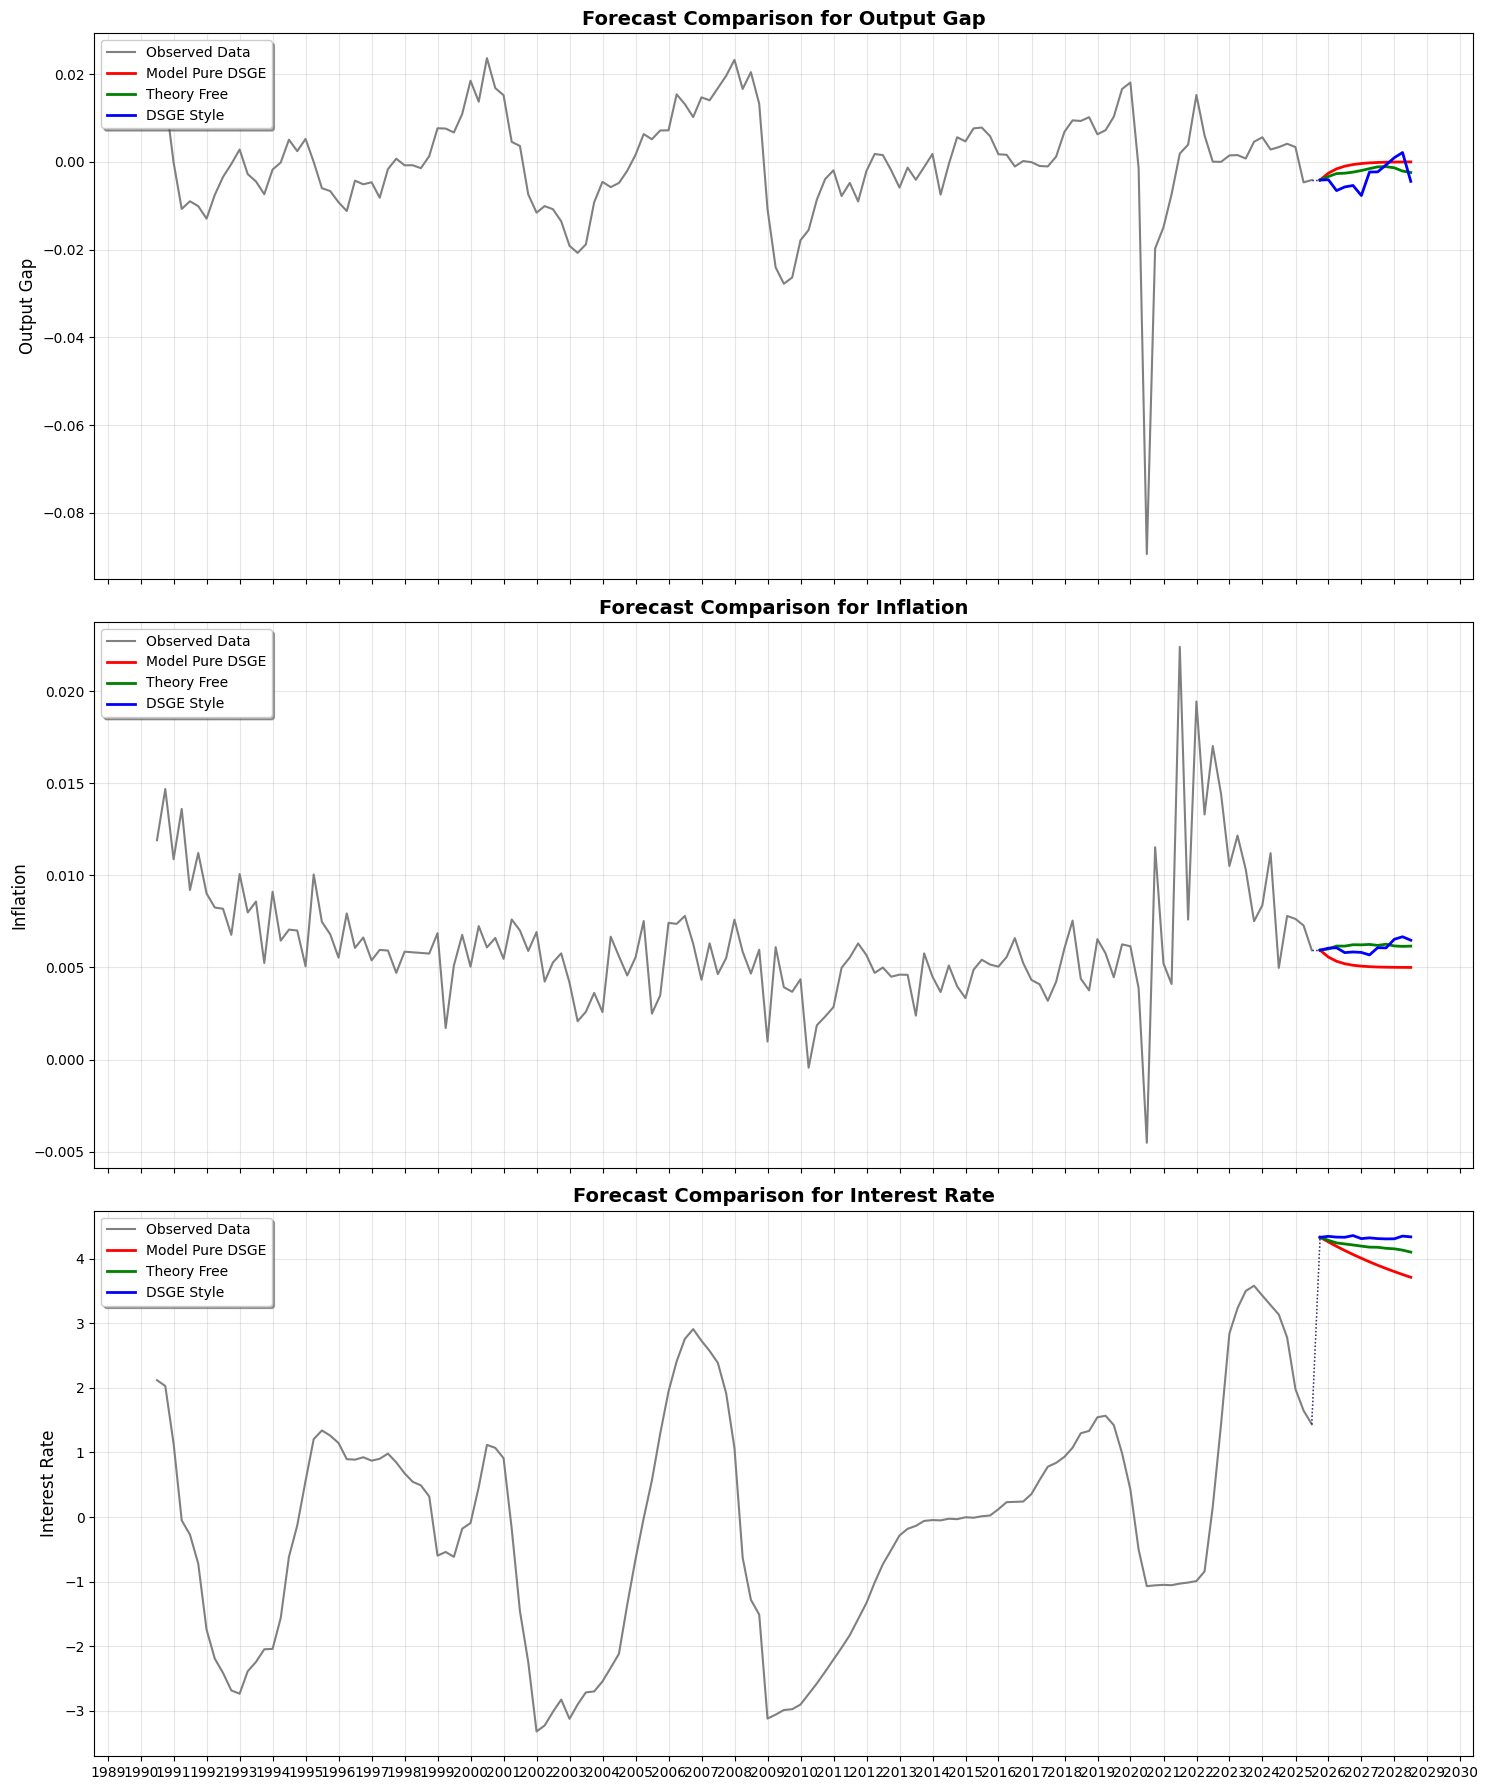

GDP FORECASTING SYSTEM

1. Preparing GDP data...
GDP data prepared from 1990-06-30 00:00:00 to 2025-06-30 00:00:00
Data shape: (141, 6)

2. Generating forecasts...
Generating TREND-REVERSION GDP forecasts for 12 periods...
Generating EMPIRICAL GDP forecasts for 12 periods...
Generating STRUCTURAL GDP forecasts for 12 periods...

3. Creating visualizations...


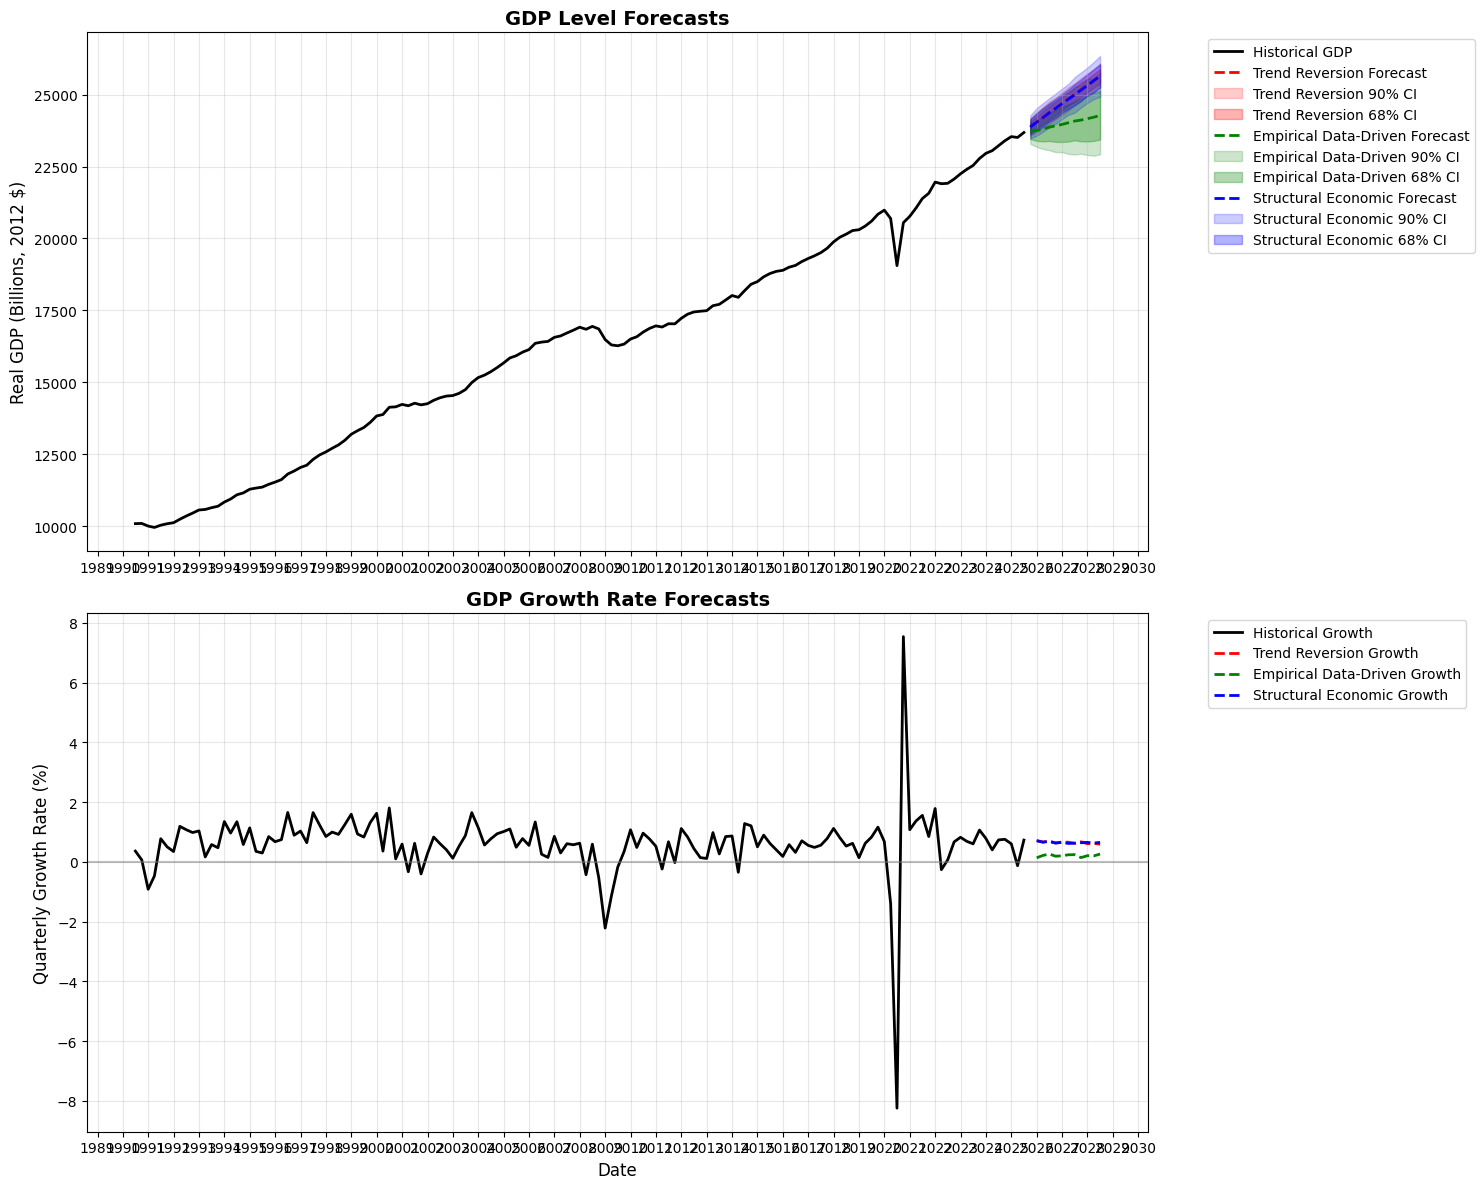


4. Forecast Summary:
               Method Final GDP Level Avg Quarterly Growth (%) Avg Annual Growth (%) Uncertainty (90% CI width %)
      Trend Reversion         25637.8                     0.60                  2.38                          3.1
Empirical Data-Driven         24280.6                     0.19                  0.77                         11.7
  Structural Economic         25652.5                     0.60                  2.39                          5.5

GDP ANALYSIS COMPLETE


In [36]:
# ============================================================================
# SECTION 12: FORECASTING CALLS
# ============================================================================

# Before running forecasts, diagnose potential issues:
diagnose_data_issues(df_obs, raw_data)

# Generate forecasts
forecast_horizon = 12
forecasts_v1 = model_pure_dsge_forecast(dsge, df_obs, raw_data, forecast_horizon)
forecasts_v2 = theory_free_dsge_forecast(dsge, df_obs, raw_data, forecast_horizon)
forecasts_v3 = dsge_style_forecast(dsge, df_obs, raw_data, forecast_horizon)#, shock_proxies=shock_proxies)

# Plot with improved function
plot_forecast_comparison_all(df_obs, raw_data, forecasts_v1, forecasts_v2, forecasts_v3, forecast_horizon)

if __name__ == "__main__":
    # Replace with your FRED API key
    API_KEY = 'ada1a8ba0569ed784226f2c26db44ab1'  # Your API key from the original code
    
    # Run the analysis
    gdp_data, forecasts, summary = run_gdp_forecasting_analysis(
        fred_api_key=API_KEY,
        forecast_horizon=12,  # 3 years of quarterly forecasts
        n_simulations=1000
    )
    
    # Access individual forecast results
    trend_reversion_forecast = forecasts[0]
    empirical_forecast = forecasts[1]
    structural_forecast = forecasts[2]